## VISION PROJECT
TRAINING AND TESTING

> CUDA ONLY VERSION

> ensure that you are using the latest PyTorch, Torchvision and Seaborn versions (otherwise there could be some issues)

### Imports

In [1]:
import copy
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary as info_summary
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms, models

### Loading data

In [2]:
def create_validation_set(data, percentage, test_transform):

  # Split data
  num_data_examples = int(len(data) * percentage)
  num_valid_examples = len(data) - num_data_examples

  # Create 'Subset' objects
  data, valid_data = torch.utils.data.random_split(data, [num_data_examples, num_valid_examples])

  # print(f"Number training examples: {len(data)}")
  # print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transform

  return data, valid_data

In [3]:
# create datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
])

# train_dataset = datasets.ImageFolder(root='/content/data/Final Training Data', transform=train_transform)
train_dataset = datasets.ImageFolder(root='Final Training Data', transform=train_transform)
test_dataset = datasets.ImageFolder(root='Original Data/test', transform=test_transform)
test_dataset, valid_dataset = create_validation_set(test_dataset, 0.5, test_transform)
# test_dataset = datasets.ImageFolder(root='/content/data/Original Data/test', transform=test_transform)


# used to plot prediciton errors
# test_dataset_original = datasets.ImageFolder(root='/content/data/Original Data/test', transform=test_transform_original)
test_dataset_original = datasets.ImageFolder(root='Original Data/test', transform=test_transform_original)

In [4]:
print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(valid_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 12000
Number validation examples: 903
Number test examples: 902


In [5]:
class_names = list(datasets.ImageFolder(root='Final Training Data').class_to_idx.keys())
# class_names = list(datasets.ImageFolder(root='/content/data/Final Training Data').class_to_idx.keys())
print(class_names)

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']


In [6]:
input_size = tuple(train_dataset[0][0].shape)
print(f'Input size: {input_size}')

Input size: (3, 224, 224)


In [7]:
INPUT_CHANNELS = input_size[0]
OUTPUT_DIM = 4 # number of classes

In [8]:
# create iterators
BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True

train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

### Support functions

In [9]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  # y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [10]:
def calculate_accuracy_ensemble(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, 1]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return round(acc.item(), 4)

In [11]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [12]:
def train_sched(model, iterator, optimizer, criterion, sched, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()
    
    # Scheduler
    sched.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [13]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [14]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [15]:
def model_training_patience(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, patience=None, model_name='best_model.pt'):

  torch.cuda.empty_cache()

  # Initialize validation loss
  best_valid_loss = float('inf')
  best_epoch = 0

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_epoch = epoch
      # Save model
      torch.save(model.state_dict(), model_name)
      print(f"\nModel checkpoint saved at epoch {epoch}\n")
    else:
        if patience is not None and epoch - best_epoch > patience:
            # stopping training
            print(f"\nEarly stopping at epoch {epoch}\n")
            break
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [16]:
def model_training_sched(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, sched, device, patience=None, model_name='best_model.pt'):

  torch.cuda.empty_cache()

  # Initialize validation loss
  best_valid_loss = float('inf')
  best_epoch = 0

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train_sched(model, train_iterator, optimizer, criterion, sched, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_epoch = epoch
      # Save model
      torch.save(model.state_dict(), model_name)
      print(f"\nModel checkpoint saved at epoch {epoch}\n")
    else:
        if patience is not None and epoch - best_epoch > patience:
            # stopping training
            print(f"\nEarly stopping at epoch {epoch}\n")
            break
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [17]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(len(train_losses))+1, train_losses, linewidth=3)
  plt.plot(np.arange(len(valid_losses))+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(len(train_accs))+1, train_accs, linewidth=3)
  plt.plot(np.arange(len(valid_accs))+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [18]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Load best weights
  model.load_state_dict(torch.load(model_name))
  # Evaluate model
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  # Print results
  print(f"Model name: {model.model_name}")
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} % \n")
  
  return round(test_loss, 3), round(test_acc, 4)

In [19]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred

In [20]:
def frame_image(image, frame_width):
    image_np = transforms.functional.to_pil_image(image)
    framed_image = np.pad(image_np, [(frame_width, frame_width), (frame_width, frame_width), (0, 0)], mode='constant', constant_values=0)
    return framed_image

In [21]:
def plot_confusion_matrix(model, labels, pred):
    plt.figure(figsize=(3, 3))
    plt.title(model.model_name)
    plt.xticks(rotation=0)
    plt.xlabel('Predicted Disease')
    plt.ylabel('Actual Disease')
    
    conf_matrix = confusion_matrix(labels, pred)
    # print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, linewidth=.5, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names, cbar=False) 
    plt.show()

In [22]:
def visualize_errors(labels, pred, rows, cols):
    pred = torch.squeeze(pred)
    labels = torch.squeeze(labels)
    
    error_indices = torch.nonzero(pred != labels).squeeze()
    
    error_indices = error_indices.numpy()
    pred = pred.numpy()
    labels = labels.numpy()
    
    nerrors = len(error_indices)
    
    fig, ax = plt.subplots(rows, cols, figsize=(7.5, 2.25 * rows), dpi=96)
    for i, idx in enumerate(error_indices[:rows * cols]):
            row = i // cols
            col = i % cols
            ax[row, col].set_title(f'Predicted: {class_names[pred[idx]]}\nActual: {class_names[labels[idx]]}')
            ax[row, col].imshow(frame_image(test_dataset[idx][0], 5))
            ax[row, col].axis('off')
            
    plt.tight_layout()
    plt.show()
    
    print(f"Wrong predictions: {nerrors}")
    
    return nerrors

In [23]:
def print_report(model, test_iterator, device, error_rows, error_cols):
  labels, pred = predict(model, test_iterator, device)
  
  plot_confusion_matrix(model, labels, pred)
  
  print()
  
  print(classification_report(labels, pred, target_names=class_names))
  
  nerrors = visualize_errors(labels, pred, error_rows, error_cols)
  
  return nerrors

In [24]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_normal_(model.weight.data)
        if model.bias is not None:
            nn.init.constant_(model.bias, 0.01)

In [25]:
def max_voting_ensemble(pred1, pred2, pred3):
    # Create a tensor of shape [1805, 3]
    concatenated_preds = torch.cat((pred1, pred2, pred3), dim=1)
    
    # Initialize a tensor to store the final ensemble predictions
    ensemble_preds = torch.zeros_like(pred1)
    
    # Iterate over each example
    for i in range(concatenated_preds.size(0)):
        # Count the occurrences of each class for the current example
        class_counts = torch.bincount(concatenated_preds[i].squeeze(), minlength=4)
        
        # Find the class with the maximum count
        max_voted_class = torch.argmax(class_counts)
        
        # Assign the max voted class as the prediction for the current example
        ensemble_preds[i] = max_voted_class
    
    return ensemble_preds

In [26]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
    
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cuda


In [27]:
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
criterion = criterion.to(device)

### Our Baseline CNN model

In [28]:
class OurBaselineCNN(nn.Module):
    def __init__(self, in_channels, output_dim):
        super(OurBaselineCNN, self).__init__()
        
        self.model_name = 'OurBaselineCNN'

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, output_dim),
        )


    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

In [29]:
our_baseline_cnn = OurBaselineCNN(in_channels=INPUT_CHANNELS, output_dim=OUTPUT_DIM).to(device)

In [30]:
summary(our_baseline_cnn, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
       BatchNorm2d-3         [-1, 16, 224, 224]              32
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
              ReLU-6         [-1, 32, 112, 112]               0
       BatchNorm2d-7         [-1, 32, 112, 112]              64
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
             ReLU-10           [-1, 64, 56, 56]               0
      BatchNorm2d-11           [-1, 64, 56, 56]             128
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          36,928
             ReLU-14           [-1, 64,


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 34.57 s
---------------------------------
Train -- Loss: 0.615, Acc: 83.44%
Val -- Loss: 0.203, Acc: 92.59%

Epoch: 2/25 -- Epoch Time: 34.01 s
---------------------------------
Train -- Loss: 0.214, Acc: 92.25%
Val -- Loss: 0.887, Acc: 78.62%

Epoch: 3/25 -- Epoch Time: 33.36 s
---------------------------------
Train -- Loss: 0.660, Acc: 88.47%
Val -- Loss: 0.841, Acc: 86.74%

Epoch: 4/25 -- Epoch Time: 33.25 s
---------------------------------
Train -- Loss: 0.296, Acc: 92.35%
Val -- Loss: 0.394, Acc: 92.80%

Epoch: 5/25 -- Epoch Time: 33.19 s
---------------------------------
Train -- Loss: 0.518, Acc: 89.26%
Val -- Loss: 0.253, Acc: 90.09%

Epoch: 6/25 -- Epoch Time: 33.30 s
---------------------------------
Train -- Loss: 0.363, Acc: 89.50%
Val -- Loss: 0.388, Acc: 94.79%

Epoch: 7/25 -- Epoch Time: 33.60 s
---------------------------------
Train -- Loss: 0.321, Acc: 91.61%
Val -- Loss: 0.879, Acc: 79.66%

Epoch: 8/25

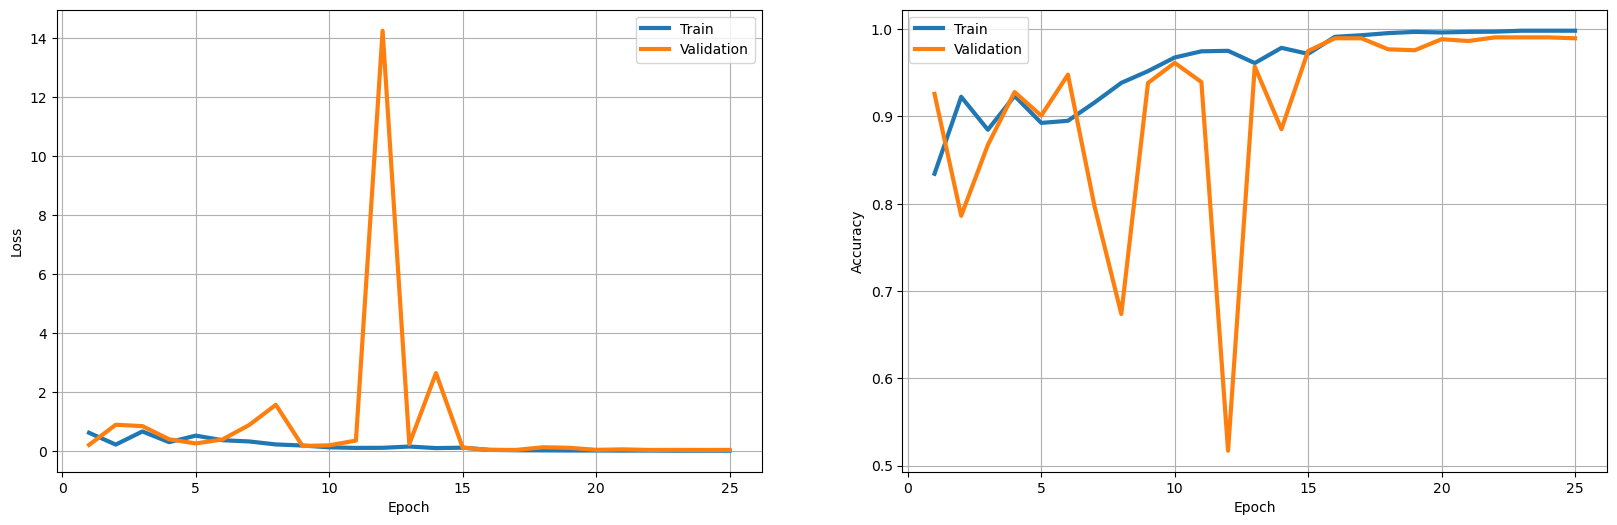

In [119]:
N_EPOCHS = 25
patience = 8
max_lr = 0.01

# optimizer = optim.Adam(our_baseline_cnn.parameters())
optimizer = optim.AdamW(our_baseline_cnn.parameters())

our_baseline_cnn.apply(weights_init)

sched = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=max_lr,
      epochs=N_EPOCHS,
      steps_per_epoch=len(train_iterator)
)

# train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
#                                                                     our_baseline_cnn,
#                                                                     train_iterator,
#                                                                     valid_iterator,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_baseline_CNN_cuda.pt'
#                                                                     )

train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
                                                                    our_baseline_cnn,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    sched,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_baseline_CNN_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [120]:
model_testing(our_baseline_cnn, valid_iterator, criterion, device, model_name='our_baseline_CNN_cuda.pt')

Model name: OurBaselineCNN
Test -- Loss: 0.033, Acc: 99.06 % 



(0.033, 0.9906)

### Baseline CNN model

In [31]:
def conv_block(in_channels, out_channels, kernel_size, padding, pool_size):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
              nn.ReLU(inplace=True),
              nn.BatchNorm2d(out_channels),
              nn.MaxPool2d(pool_size),
              ]

    return nn.Sequential(*layers)

In [32]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
class BaselineCNN(nn.Module):
    def __init__(self, in_channels, output_dim):
        super(BaselineCNN, self).__init__()
        
        self.model_name = 'BaselineCNN'

        self.conv = nn.Sequential(
            conv_block(in_channels, 32, 6, 'same', 2),
            conv_block(32, 32, 5, 'same', 2),
            conv_block(32, 32, 4, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
            conv_block(32, 32, 3, 'same', 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(32, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )


    def forward(self, x):
        out = self.conv(x)
        out = self.classifier(out)

        return out

In [34]:
baseline_cnn = BaselineCNN(in_channels=INPUT_CHANNELS, output_dim=OUTPUT_DIM)

In [35]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
baseline_cnn = baseline_cnn.to(device)

In [36]:
# print(f"The model has {count_parameters(baseline_cnn):,} trainable parameters.")
summary(baseline_cnn, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           3,488
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]          25,632
              ReLU-6         [-1, 32, 112, 112]               0
       BatchNorm2d-7         [-1, 32, 112, 112]              64
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]          16,416
             ReLU-10           [-1, 32, 56, 56]               0
      BatchNorm2d-11           [-1, 32, 56, 56]              64
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,248
             ReLU-14           [-1, 32,

c:\Users\loren\anaconda3\envs\vision\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv2d(input, weight, bias, self.stride,


In [37]:
optimizer = optim.Adam(baseline_cnn.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 50.10 s
---------------------------------
Train -- Loss: 0.283, Acc: 89.52%
Val -- Loss: 0.697, Acc: 79.78%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 49.60 s
---------------------------------
Train -- Loss: 0.103, Acc: 96.56%
Val -- Loss: 0.521, Acc: 79.23%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 48.80 s
---------------------------------
Train -- Loss: 0.065, Acc: 97.91%
Val -- Loss: 0.368, Acc: 85.49%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 49.41 s
---------------------------------
Train -- Loss: 0.058, Acc: 98.06%
Val -- Loss: 0.112, Acc: 96.35%

Epoch: 5/25 -- Epoch Time: 50.18 s
---------------------------------
Train -- Loss: 0.037, Acc: 98.79%
Val -- Loss: 0.805, Acc: 78.41%

Epoch: 6/25 -- Epoch Time: 49.35 s
---------------------------------
Train -- Loss: 0.051, Acc: 98.47%
Val -- Loss: 0.364, Acc: 85.51%

Epoch: 7/25 -- Epoch Time: 48.98 s
----

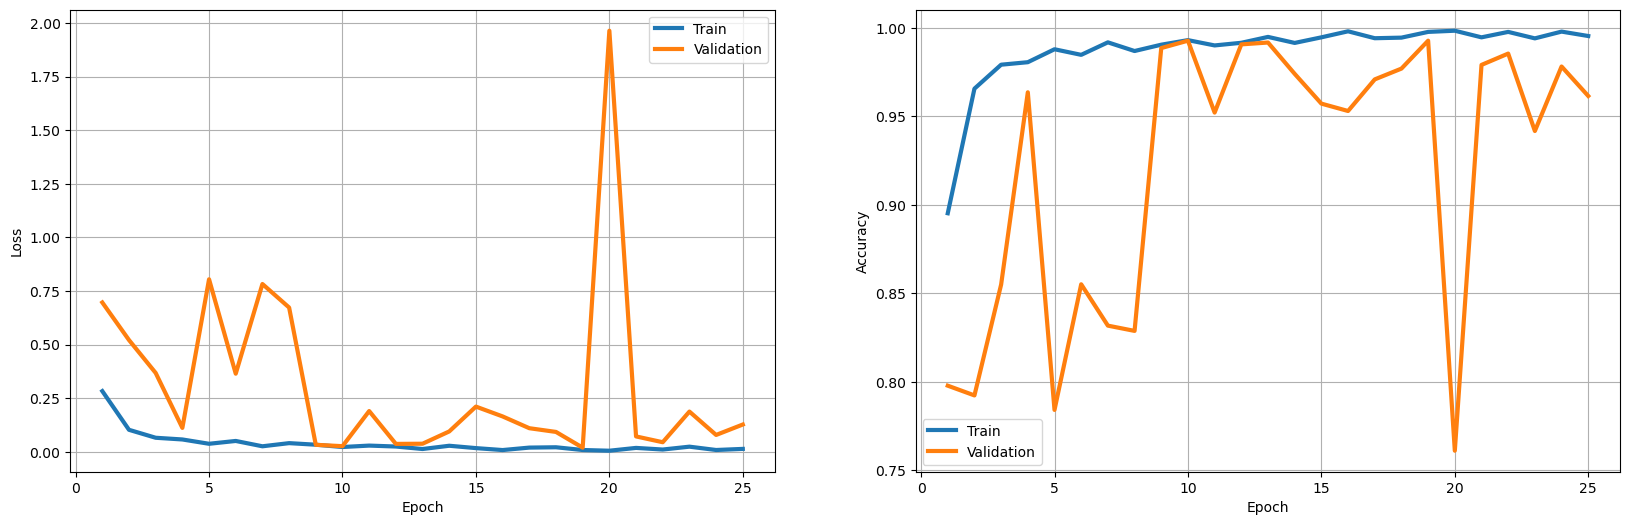

In [43]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    baseline_cnn,
                                                                    train_iterator,
                                                                    valid_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='baseline_CNN_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [46]:
model_testing(baseline_cnn, valid_iterator, criterion, device, model_name='baseline_CNN_cuda.pt')

Model name: BaselineCNN
Test -- Loss: 0.019, Acc: 99.27 % 



(0.019, 0.9927)

### Recreate datasets (to use pretrained models on ImageNet)

In [38]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [39]:
train_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_imagenet, std_imagenet)
])

test_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_imagenet, std_imagenet)
])

# train_dataset_imagenet = datasets.ImageFolder(root='/content/data/Final Training Data', transform=train_transform_imagenet)
train_dataset_imagenet = datasets.ImageFolder(root='Final Training Data', transform=train_transform_imagenet)
test_dataset_imagenet = datasets.ImageFolder(root='Original Data/test', transform=test_transform_imagenet)
test_dataset_imagenet, valid_dataset_imagenet = create_validation_set(test_dataset_imagenet, 0.5, test_transform_imagenet)
# test_dataset_imagenet = datasets.ImageFolder(root='/content/data/Original Data/test', transform=test_transform_imagenet)

In [40]:
# create iterators
BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True

train_iterator_imagenet = DataLoader(train_dataset_imagenet, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_iterator_imagenet = DataLoader(valid_dataset_imagenet, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_iterator_imagenet = DataLoader(test_dataset_imagenet, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

### Our DenseNet121

In [41]:
class OurDenseNet121(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurDenseNet121'

        self.dense_net_features = model.features

        # Freeze all "features" layers
        for parameter in self.dense_net_features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier.in_features
        self.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.dense_net_features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = nn.Dropout(0.2)(x)
        x = self.fc(x)
        return x

In [42]:
dense_net121 = models.densenet121(weights="DEFAULT")

our_dense_net121_extract = OurDenseNet121(OUTPUT_DIM, dense_net121).to(device)

In [43]:
# TODO: torchsummary does not work, I had to use summary from torchinfo
info_summary(our_dense_net121_extract, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
OurDenseNet121                           [32, 4]                   --
├─Sequential: 1-1                        [32, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [32, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [32, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [32, 32, 56, 56]          (45,440)
│    │    └─_DenseLayer: 3-2             [32, 32, 56, 56]          (49,600)
│    │    └─_DenseLayer: 3-3             [32, 32, 56, 56]          (53,760)
│    │    └─_DenseLayer: 3-4             [32, 32, 56, 56]          (57,920)
│    │    └─_DenseLayer: 3-5             [32, 32, 56, 56]          (62,080)
│    │    └─_DenseLayer: 3-6             [32, 3


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 73.15 s
---------------------------------
Train -- Loss: 0.313, Acc: 89.47%
Val -- Loss: 0.086, Acc: 97.60%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 73.06 s
---------------------------------
Train -- Loss: 0.071, Acc: 98.23%
Val -- Loss: 0.054, Acc: 98.96%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 72.60 s
---------------------------------
Train -- Loss: 0.050, Acc: 98.67%
Val -- Loss: 0.045, Acc: 98.54%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 71.05 s
---------------------------------
Train -- Loss: 0.040, Acc: 98.96%
Val -- Loss: 0.042, Acc: 98.96%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 70.98 s
---------------------------------
Train -- Loss: 0.034, Acc: 99.18%
Val -- Loss: 0.036, Acc: 98.75%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 70.76 s
---------------------------------
Train -- Loss: 0.027, Acc: 99.34%


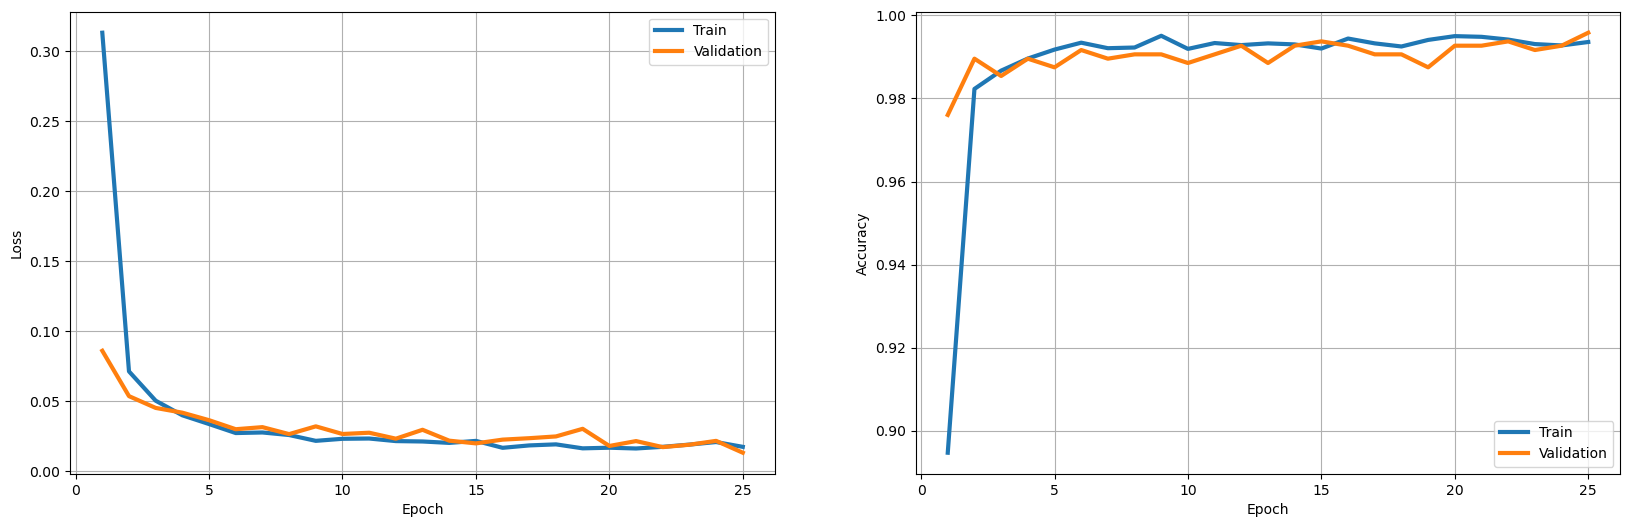

In [77]:
N_EPOCHS = 25
patience = 8
#  max_lr = 0.01

optimizer = optim.Adam(our_dense_net121_extract.parameters())
# optimizer = optim.AdamW(our_dense_net121_extract.parameters())

our_dense_net121_extract.apply(weights_init)

# sched = torch.optim.lr_scheduler.OneCycleLR(
#       optimizer,
#       max_lr=max_lr,
#       epochs=N_EPOCHS,
#       steps_per_epoch=len(train_iterator_imagenet)
# )

# train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
#                                                                     our_dense_net121_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     sched,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_dense_net121_cuda.pt'
#                                                                     )

train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    our_dense_net121_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_dense_net121_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [83]:
model_testing(our_dense_net121_extract, valid_iterator_imagenet, criterion, device, model_name='our_dense_net121_cuda.pt')

Model name: OurDenseNet121
Test -- Loss: 0.023, Acc: 99.27 % 



(0.023, 0.9927)

### DenseNet121

Transfer learning - Feature Extraction

In [44]:
class DenseNet121(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'DenseNet121'

        self.dense_net_features = model.features

        # Freeze all "features" layers
        for parameter in self.dense_net_features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier.in_features
        self.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.dense_net_features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [45]:
dense_net121 = models.densenet121(weights="DEFAULT")

dense_net121_extract = DenseNet121(OUTPUT_DIM, dense_net121)

In [46]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
dense_net121_extract = dense_net121_extract.to(device)

In [47]:
# TODO: torchsummary does not work, I had to use summary from torchinfo
info_summary(dense_net121_extract, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet121                              [32, 4]                   --
├─Sequential: 1-1                        [32, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [32, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [32, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [32, 32, 56, 56]          (45,440)
│    │    └─_DenseLayer: 3-2             [32, 32, 56, 56]          (49,600)
│    │    └─_DenseLayer: 3-3             [32, 32, 56, 56]          (53,760)
│    │    └─_DenseLayer: 3-4             [32, 32, 56, 56]          (57,920)
│    │    └─_DenseLayer: 3-5             [32, 32, 56, 56]          (62,080)
│    │    └─_DenseLayer: 3-6             [32, 3

In [48]:
optimizer = optim.Adam(dense_net121_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 73.72 s
---------------------------------
Train -- Loss: 0.195, Acc: 96.11%
Val -- Loss: 0.059, Acc: 98.96%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 71.40 s
---------------------------------
Train -- Loss: 0.049, Acc: 99.06%
Val -- Loss: 0.040, Acc: 99.17%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 72.61 s
---------------------------------
Train -- Loss: 0.033, Acc: 99.36%
Val -- Loss: 0.030, Acc: 99.27%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 73.15 s
---------------------------------
Train -- Loss: 0.026, Acc: 99.39%
Val -- Loss: 0.026, Acc: 99.27%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 71.98 s
---------------------------------
Train -- Loss: 0.021, Acc: 99.50%
Val -- Loss: 0.023, Acc: 99.38%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 72.58 s
---------------------------------
Train -- Loss: 0.019, Acc: 99.53%


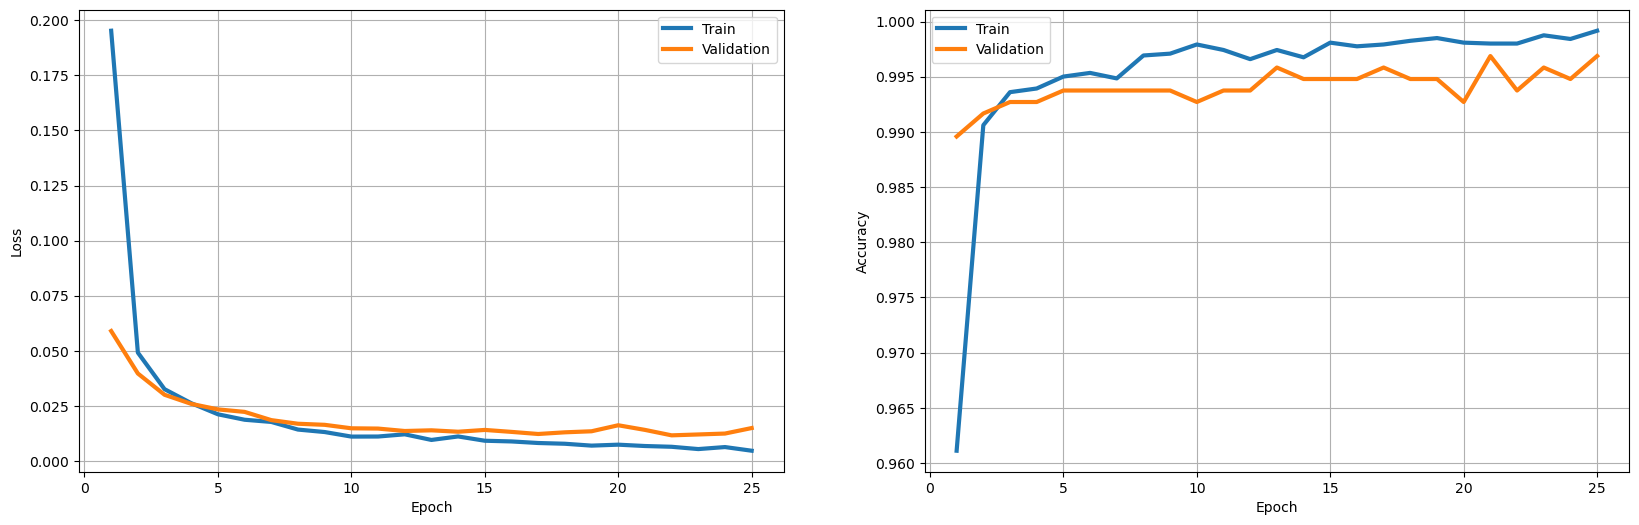

In [73]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    dense_net121_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='dense_net121_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [74]:
model_testing(dense_net121_extract, valid_iterator_imagenet, criterion, device, model_name='dense_net121_cuda.pt')

Model name: DenseNet121
Test -- Loss: 0.012, Acc: 99.38 % 



(0.012, 0.9938)

### Our EfficientNetB1

In [49]:
class OurEfficientNetB1(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurEfficientNetB1'

        self.features = model.features

        # Freeze all "features" layers
        for parameter in self.features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier[1].in_features
        self.classifier = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = nn.Dropout(p=0.2)(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [50]:
efficientnet_b1 = models.efficientnet_b1(weights='DEFAULT')

our_efficientnet_b1_extract = OurEfficientNetB1(OUTPUT_DIM, efficientnet_b1).to(device)

In [51]:
summary(our_efficientnet_b1_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 54.45 s
---------------------------------
Train -- Loss: 0.747, Acc: 82.66%
Val -- Loss: 0.283, Acc: 97.19%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 54.12 s
---------------------------------
Train -- Loss: 0.229, Acc: 96.24%
Val -- Loss: 0.103, Acc: 98.33%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 55.13 s
---------------------------------
Train -- Loss: 0.111, Acc: 97.75%
Val -- Loss: 0.051, Acc: 98.54%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 54.72 s
---------------------------------
Train -- Loss: 0.067, Acc: 98.49%
Val -- Loss: 0.038, Acc: 99.06%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 54.95 s
---------------------------------
Train -- Loss: 0.056, Acc: 98.50%
Val -- Loss: 0.028, Acc: 98.96%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 54.77 s
---------------------------------
Train -- Loss: 0.047, Acc: 98.59%


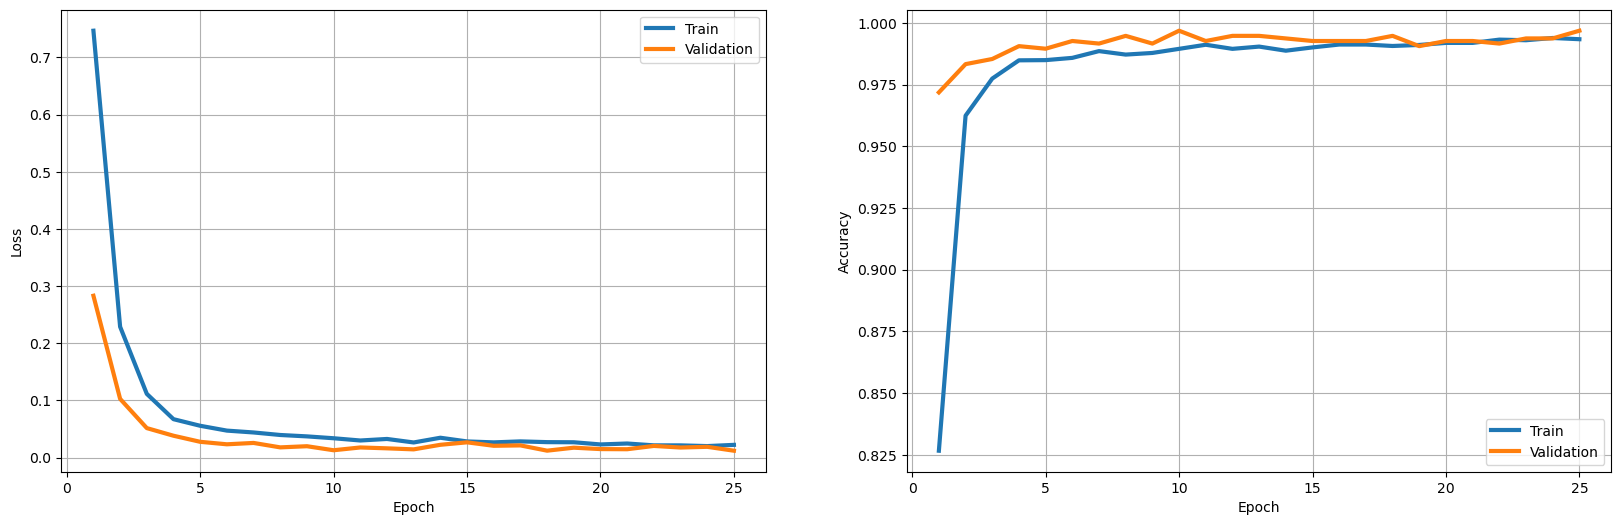

In [81]:
N_EPOCHS = 25
patience = 8
max_lr = 0.01

# optimizer = optim.Adam(our_efficientnet_b1_extract.parameters())
optimizer = optim.AdamW(our_efficientnet_b1_extract.parameters())

our_efficientnet_b1_extract.apply(weights_init)

sched = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=max_lr,
      epochs=N_EPOCHS,
      steps_per_epoch=len(train_iterator_imagenet)
)


# train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
#                                                                     our_efficientnet_b1_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_efficientnet_b1_cuda.pt'
#                                                                     )

train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
                                                                    our_efficientnet_b1_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    sched,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_efficientnet_b1_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [84]:
model_testing(our_efficientnet_b1_extract, valid_iterator_imagenet, criterion, device, model_name='our_efficientnet_b1_cuda.pt')

Model name: OurEfficientNetB1
Test -- Loss: 0.017, Acc: 99.27 % 



(0.017, 0.9927)

### EfficientNetB7

In [52]:
class EfficientNetB7(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'EfficientNetB7'

        self.features = model.features

        # Freeze all "features" layers
        for parameter in self.features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier[1].in_features
        self.classifier = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = nn.Dropout(p=0.5)(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [53]:
efficientnet_b7 = models.efficientnet_b7(weights='DEFAULT')

efficientnet_b7_extract = EfficientNetB7(OUTPUT_DIM, efficientnet_b7)

In [54]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
efficientnet_b7_extract = efficientnet_b7_extract.to(device)

In [55]:
summary(efficientnet_b7_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1

In [56]:
optimizer = optim.Adam(efficientnet_b7_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 217.58 s
---------------------------------
Train -- Loss: 0.485, Acc: 88.41%
Val -- Loss: 0.175, Acc: 95.10%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 217.55 s
---------------------------------
Train -- Loss: 0.228, Acc: 93.73%
Val -- Loss: 0.131, Acc: 96.56%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 217.52 s
---------------------------------
Train -- Loss: 0.188, Acc: 94.22%
Val -- Loss: 0.131, Acc: 96.35%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 217.66 s
---------------------------------
Train -- Loss: 0.164, Acc: 94.88%
Val -- Loss: 0.115, Acc: 95.42%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 217.61 s
---------------------------------
Train -- Loss: 0.155, Acc: 94.97%
Val -- Loss: 0.112, Acc: 96.15%

Epoch: 6/25 -- Epoch Time: 217.18 s
---------------------------------
Train -- Loss: 0.148, Acc: 94.99%
Val -- Loss: 0.113, Acc: 96.04

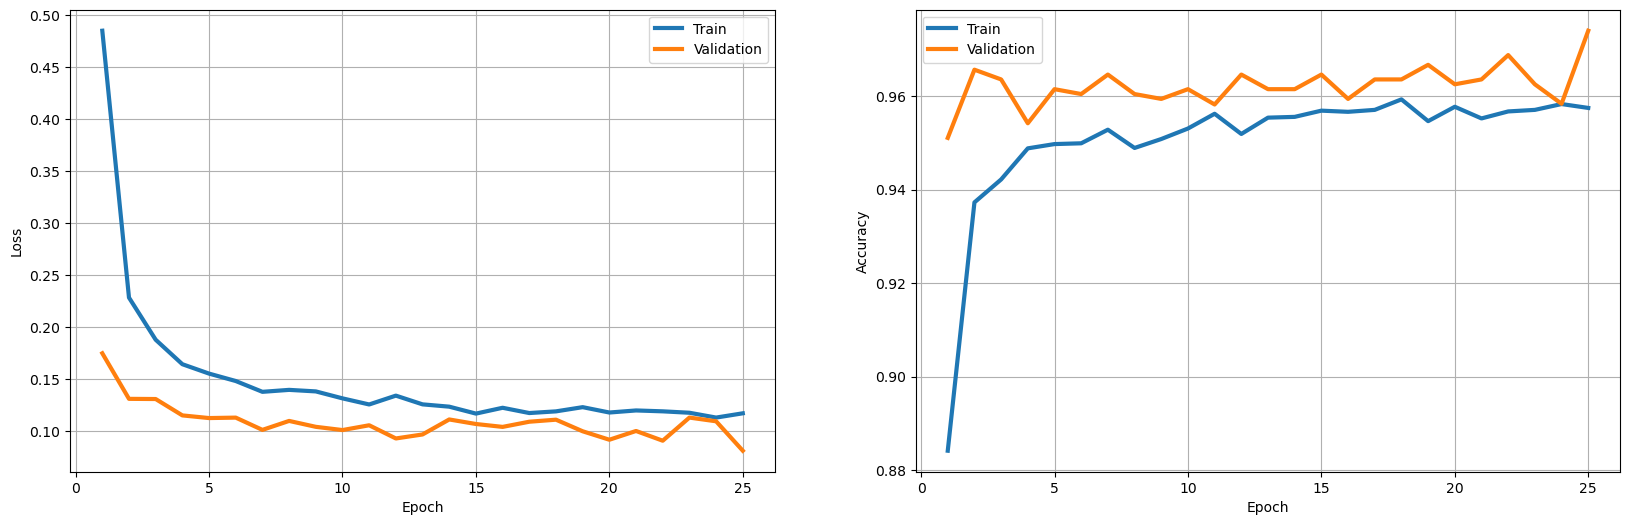

In [101]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    efficientnet_b7_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='efficientnet_b7_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [102]:
model_testing(efficientnet_b7_extract, valid_iterator_imagenet, criterion, device, model_name='efficientnet_b7_cuda.pt')

Model name: EfficientNetB7
Test -- Loss: 0.088, Acc: 96.98 % 



(0.088, 0.9698)

### Our MobileNetV2

In [57]:
class OurMobileNetV2(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurMobileNetV2'

        self.features = model.features

        # Freeze all "features" layers
        for parameter in self.features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier[1].in_features
        self.classifier = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = nn.Dropout(p=0.2)(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [58]:
mobilenetv2 = models.mobilenet_v2(weights="DEFAULT")

our_mobilenetv2_extract = OurMobileNetV2(OUTPUT_DIM, mobilenetv2).to(device)

In [59]:
summary(our_mobilenetv2_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 35.67 s
---------------------------------
Train -- Loss: 0.633, Acc: 81.98%
Val -- Loss: 0.232, Acc: 95.00%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 34.01 s
---------------------------------
Train -- Loss: 0.184, Acc: 96.38%
Val -- Loss: 0.109, Acc: 96.98%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 34.24 s
---------------------------------
Train -- Loss: 0.100, Acc: 97.59%
Val -- Loss: 0.071, Acc: 97.71%

Epoch: 4/25 -- Epoch Time: 33.88 s
---------------------------------
Train -- Loss: 0.070, Acc: 98.01%
Val -- Loss: 0.080, Acc: 97.08%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 34.32 s
---------------------------------
Train -- Loss: 0.053, Acc: 98.34%
Val -- Loss: 0.058, Acc: 98.23%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 35.11 s
---------------------------------
Train -- Loss: 0.047, Acc: 98.51%
Val -- Loss: 0.058, Acc: 97.60%

Mod

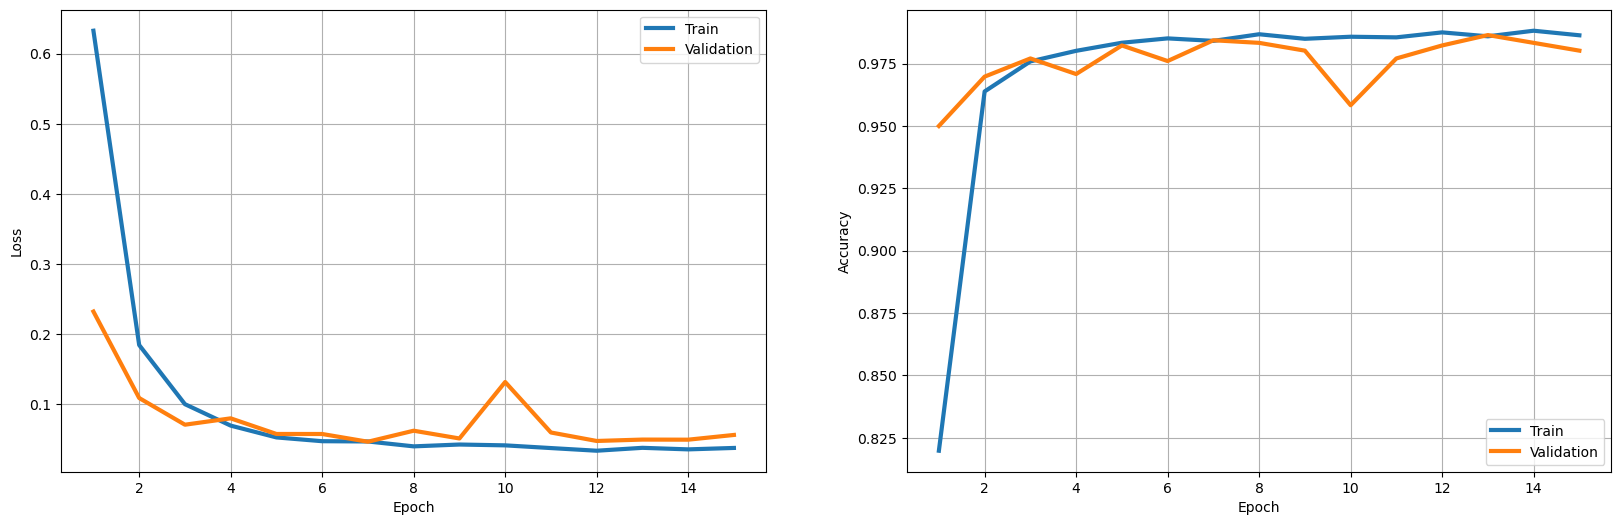

In [106]:
N_EPOCHS = 25
patience = 8
max_lr = 0.01

# optimizer = optim.Adam(our_mobilenetv2_extract.parameters())
optimizer = optim.AdamW(our_mobilenetv2_extract.parameters())

our_mobilenetv2_extract.apply(weights_init)

sched = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=max_lr,
      epochs=N_EPOCHS,
      steps_per_epoch=len(train_iterator_imagenet)
)

# train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
#                                                                     our_mobilenetv2_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_mobilenetv2_cuda.pt'
#                                                                     )

train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
                                                                    our_mobilenetv2_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    sched,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_mobilenetv2_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [107]:
model_testing(our_mobilenetv2_extract, valid_iterator_imagenet, criterion, device, model_name='our_mobilenetv2_cuda.pt')

Model name: OurMobileNetV2
Test -- Loss: 0.048, Acc: 98.33 % 



(0.048, 0.9833)

### MobileNetV2

In [60]:
class MobileNetV2(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'MobileNetV2'

        self.features = model.features

        # Freeze all "features" layers
        for parameter in self.features.parameters():
            parameter.requires_grad = False

        in_features = model.classifier[1].in_features
        self.classifier = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = nn.Dropout(p=0.2)(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [61]:
mobilenetv2 = models.mobilenet_v2(weights="DEFAULT")

mobilenetv2_extract = MobileNetV2(OUTPUT_DIM, mobilenetv2)

In [62]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
mobilenetv2_extract = mobilenetv2_extract.to(device)

In [63]:
summary(mobilenetv2_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [64]:
optimizer = optim.Adam(mobilenetv2_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 34.63 s
---------------------------------
Train -- Loss: 0.401, Acc: 91.87%
Val -- Loss: 0.149, Acc: 96.25%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 35.20 s
---------------------------------
Train -- Loss: 0.138, Acc: 97.20%
Val -- Loss: 0.098, Acc: 97.40%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 35.32 s
---------------------------------
Train -- Loss: 0.099, Acc: 97.88%
Val -- Loss: 0.079, Acc: 97.29%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 35.16 s
---------------------------------
Train -- Loss: 0.081, Acc: 98.07%
Val -- Loss: 0.061, Acc: 97.81%

Epoch: 5/25 -- Epoch Time: 33.84 s
---------------------------------
Train -- Loss: 0.068, Acc: 98.40%
Val -- Loss: 0.061, Acc: 98.02%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 33.99 s
---------------------------------
Train -- Loss: 0.062, Acc: 98.50%
Val -- Loss: 0.052, Acc: 98.33%

Mod

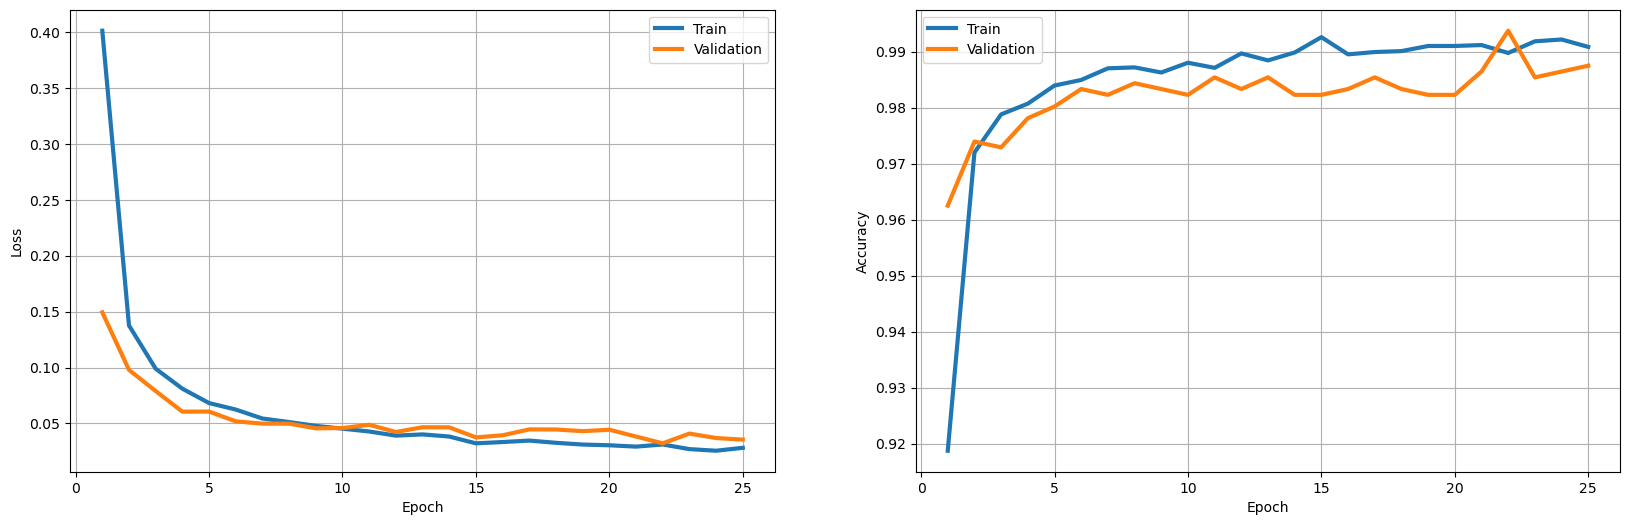

In [113]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    mobilenetv2_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='mobilenetv2_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [114]:
model_testing(mobilenetv2_extract, valid_iterator_imagenet, criterion, device, model_name='mobilenetv2_cuda.pt')

Model name: MobileNetV2
Test -- Loss: 0.031, Acc: 98.65 % 



(0.031, 0.9865)

### Our ResNet18

In [65]:
class OurResNet18(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurResNet18'

        self.model = model

        for parameter in self.model.parameters():
            parameter.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, output_dim)

        for parameter in self.model.fc.parameters():
            parameter.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return x

In [66]:
resnet18 = models.resnet18(weights="DEFAULT")

our_resnet18_extract = OurResNet18(OUTPUT_DIM, resnet18).to(device)

In [67]:
summary(our_resnet18_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 33.43 s
---------------------------------
Train -- Loss: 0.667, Acc: 76.75%
Val -- Loss: 0.223, Acc: 94.26%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 31.40 s
---------------------------------
Train -- Loss: 0.169, Acc: 95.92%
Val -- Loss: 0.116, Acc: 97.40%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 29.85 s
---------------------------------
Train -- Loss: 0.091, Acc: 97.57%
Val -- Loss: 0.066, Acc: 97.71%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 29.90 s
---------------------------------
Train -- Loss: 0.061, Acc: 98.17%
Val -- Loss: 0.053, Acc: 98.75%

Epoch: 5/25 -- Epoch Time: 30.52 s
---------------------------------
Train -- Loss: 0.054, Acc: 98.23%
Val -- Loss: 0.059, Acc: 97.50%

Epoch: 6/25 -- Epoch Time: 29.92 s
---------------------------------
Train -- Loss: 0.076, Acc: 97.45%
Val -- Loss: 0.182, Acc: 93.74%

Model checkpoint saved at epoch 6


Epo

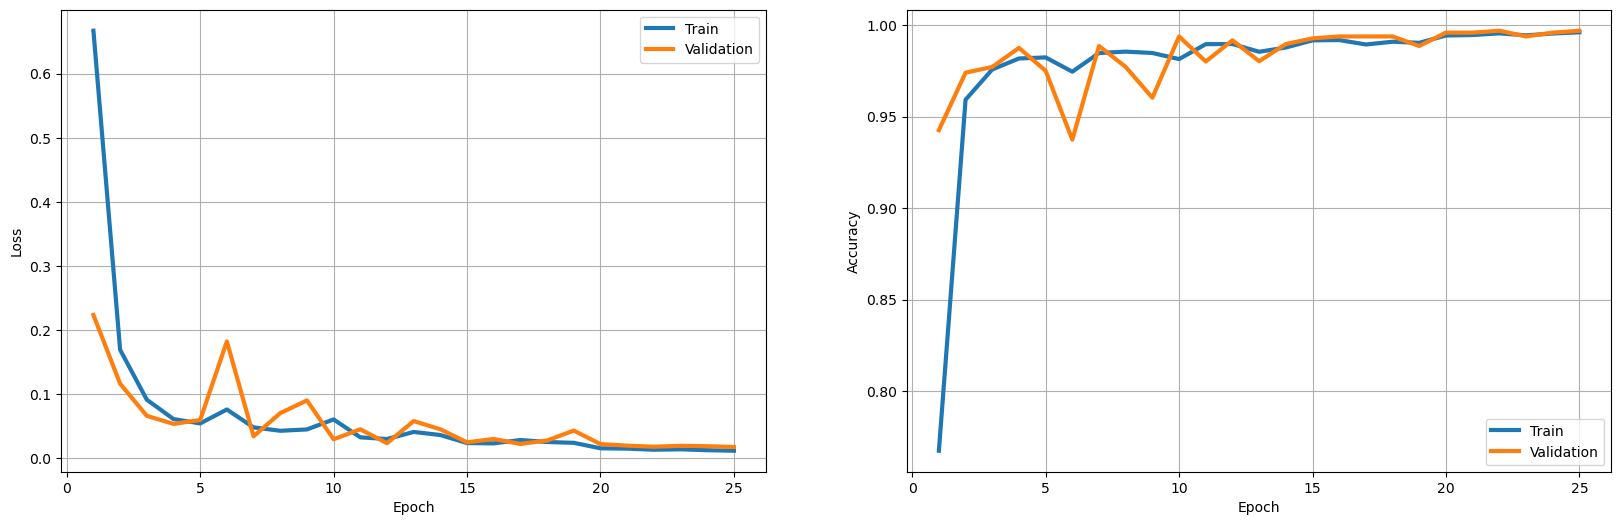

In [124]:
N_EPOCHS = 25
patience = 8
max_lr = 0.01

# optimizer = optim.Adam(our_resnet18_extract.parameters())
optimizer = optim.AdamW(our_resnet18_extract.parameters())

our_resnet18_extract.apply(weights_init)

sched = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=max_lr,
      epochs=N_EPOCHS,
      steps_per_epoch=len(train_iterator_imagenet)
)

# train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
#                                                                     our_resnet18_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_resnet18_cuda.pt'
#                                                                     )

train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
                                                                    our_resnet18_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    sched,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_resnet18_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [125]:
model_testing(our_resnet18_extract, valid_iterator_imagenet, criterion, device, model_name='our_resnet18_cuda.pt')

Model name: OurResNet18
Test -- Loss: 0.017, Acc: 99.69 % 



(0.017, 0.9969)

### Our ResNet50

In [68]:
class OurResNet50(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurResNet50'

        self.model = model

        for parameter in self.model.parameters():
            parameter.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, output_dim)

        for parameter in self.model.fc.parameters():
            parameter.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return x

In [69]:
resnet50 = models.resnet50(weights="DEFAULT")

our_resnet50_extract = OurResNet50(OUTPUT_DIM, resnet50).to(device)

In [70]:
summary(our_resnet50_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 65.29 s
---------------------------------
Train -- Loss: 0.587, Acc: 84.91%
Val -- Loss: 0.220, Acc: 95.83%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 64.84 s
---------------------------------
Train -- Loss: 0.151, Acc: 97.02%
Val -- Loss: 0.100, Acc: 98.02%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 64.87 s
---------------------------------
Train -- Loss: 0.074, Acc: 98.35%
Val -- Loss: 0.056, Acc: 99.06%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 64.80 s
---------------------------------
Train -- Loss: 0.044, Acc: 99.09%
Val -- Loss: 0.037, Acc: 99.38%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 64.76 s
---------------------------------
Train -- Loss: 0.027, Acc: 99.45%
Val -- Loss: 0.032, Acc: 98.85%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 64.95 s
---------------------------------
Train -- Loss: 0.018, Acc: 99.63%


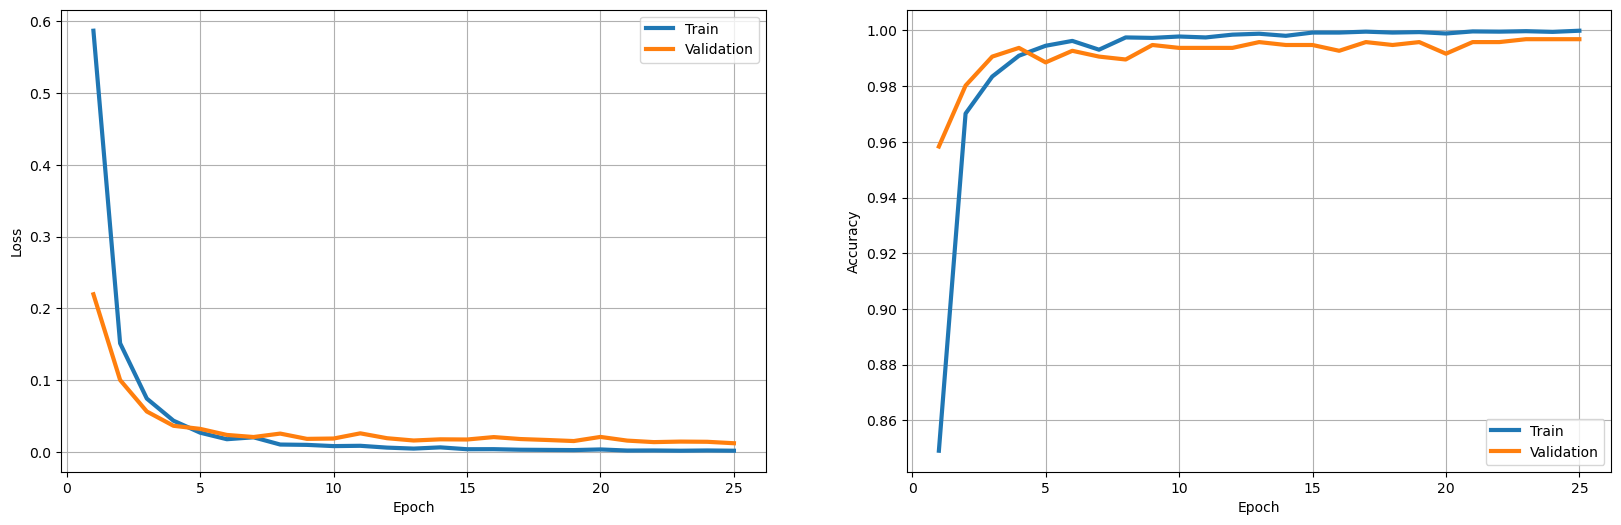

In [129]:
N_EPOCHS = 25
patience = 8
max_lr = 0.01

optimizer = optim.Adam(our_resnet50_extract.parameters())
# optimizer = optim.AdamW(our_resnet50_extract.parameters())

our_resnet50_extract.apply(weights_init)

sched = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=max_lr,
      epochs=N_EPOCHS,
      steps_per_epoch=len(train_iterator_imagenet)
)

# train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
#                                                                     our_resnet50_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_resnet50_cuda.pt'
#                                                                     )

train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
                                                                    our_resnet50_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    sched,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_resnet50_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [130]:
model_testing(our_resnet50_extract, valid_iterator_imagenet, criterion, device, model_name='our_resnet50_cuda.pt')

Model name: OurResNet50
Test -- Loss: 0.012, Acc: 99.69 % 



(0.012, 0.9969)

### ResNet50

In [71]:
class ResNet50(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'ResNet50'

        self.model = model

        for parameter in self.model.parameters():
            parameter.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, output_dim)

        for parameter in self.model.fc.parameters():
            parameter.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        return x

In [72]:
resnet50 = models.resnet50(weights="DEFAULT")

resnet50_extract = ResNet50(OUTPUT_DIM, resnet50)

In [73]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
resnet50_extract = resnet50_extract.to(device)

In [74]:
summary(resnet50_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [75]:
optimizer = optim.Adam(resnet50_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 65.78 s
---------------------------------
Train -- Loss: 0.353, Acc: 93.37%
Val -- Loss: 0.136, Acc: 97.81%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 65.00 s
---------------------------------
Train -- Loss: 0.108, Acc: 98.08%
Val -- Loss: 0.086, Acc: 98.54%

Model checkpoint saved at epoch 2


Epoch: 3/25 -- Epoch Time: 65.78 s
---------------------------------
Train -- Loss: 0.072, Acc: 98.79%
Val -- Loss: 0.064, Acc: 98.75%

Model checkpoint saved at epoch 3


Epoch: 4/25 -- Epoch Time: 65.05 s
---------------------------------
Train -- Loss: 0.054, Acc: 99.15%
Val -- Loss: 0.052, Acc: 99.06%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 68.31 s
---------------------------------
Train -- Loss: 0.043, Acc: 99.21%
Val -- Loss: 0.047, Acc: 98.96%

Model checkpoint saved at epoch 5


Epoch: 6/25 -- Epoch Time: 66.47 s
---------------------------------
Train -- Loss: 0.036, Acc: 99.33%


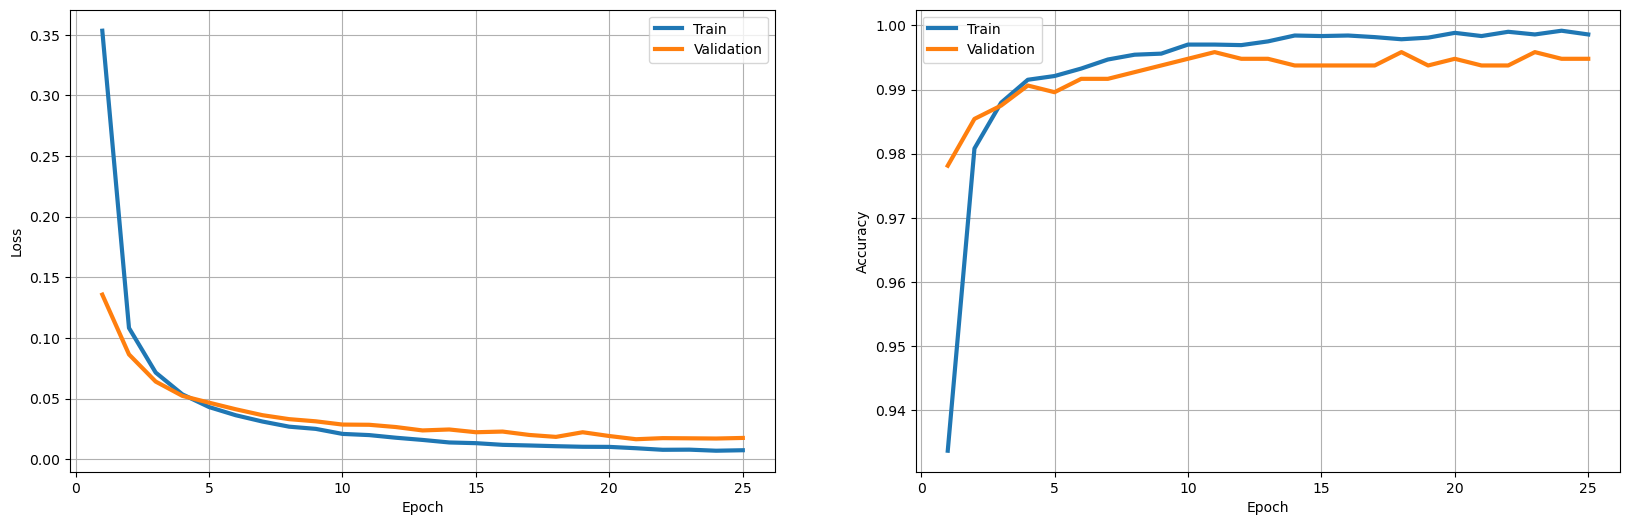

In [136]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    resnet50_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='resnet50_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [137]:
model_testing(resnet50_extract, valid_iterator_imagenet, criterion, device, model_name='resnet50_cuda.pt')

Model name: ResNet50
Test -- Loss: 0.017, Acc: 99.38 % 



(0.017, 0.9938)

### Our VGG11

In [76]:
class OurVGG11(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurVGG11'
        
        self.model = model

        # Freeze all "features" layers
        for parameter in self.model.features.parameters():
            parameter.requires_grad = False
        
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.model(x)
        return x

In [77]:
vgg11_bn = models.vgg11_bn(weights="DEFAULT")

our_vgg11_extract = OurVGG11(OUTPUT_DIM, vgg11_bn).to(device)

In [78]:
summary(our_vgg11_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,


Model checkpoint saved at epoch 0


Epoch: 1/35 -- Epoch Time: 79.74 s
---------------------------------
Train -- Loss: 0.659, Acc: 93.23%
Val -- Loss: 0.011, Acc: 99.69%

Epoch: 2/35 -- Epoch Time: 75.56 s
---------------------------------
Train -- Loss: 0.051, Acc: 98.57%
Val -- Loss: 0.022, Acc: 99.48%

Model checkpoint saved at epoch 2


Epoch: 3/35 -- Epoch Time: 79.47 s
---------------------------------
Train -- Loss: 0.048, Acc: 98.87%
Val -- Loss: 0.008, Acc: 99.69%

Epoch: 4/35 -- Epoch Time: 76.18 s
---------------------------------
Train -- Loss: 0.053, Acc: 98.92%
Val -- Loss: 0.013, Acc: 99.48%

Epoch: 5/35 -- Epoch Time: 76.68 s
---------------------------------
Train -- Loss: 0.078, Acc: 98.75%
Val -- Loss: 0.121, Acc: 97.59%

Epoch: 6/35 -- Epoch Time: 77.19 s
---------------------------------
Train -- Loss: 0.048, Acc: 99.17%
Val -- Loss: 0.105, Acc: 98.65%

Model checkpoint saved at epoch 6


Epoch: 7/35 -- Epoch Time: 79.85 s
---------------------------------
Train 

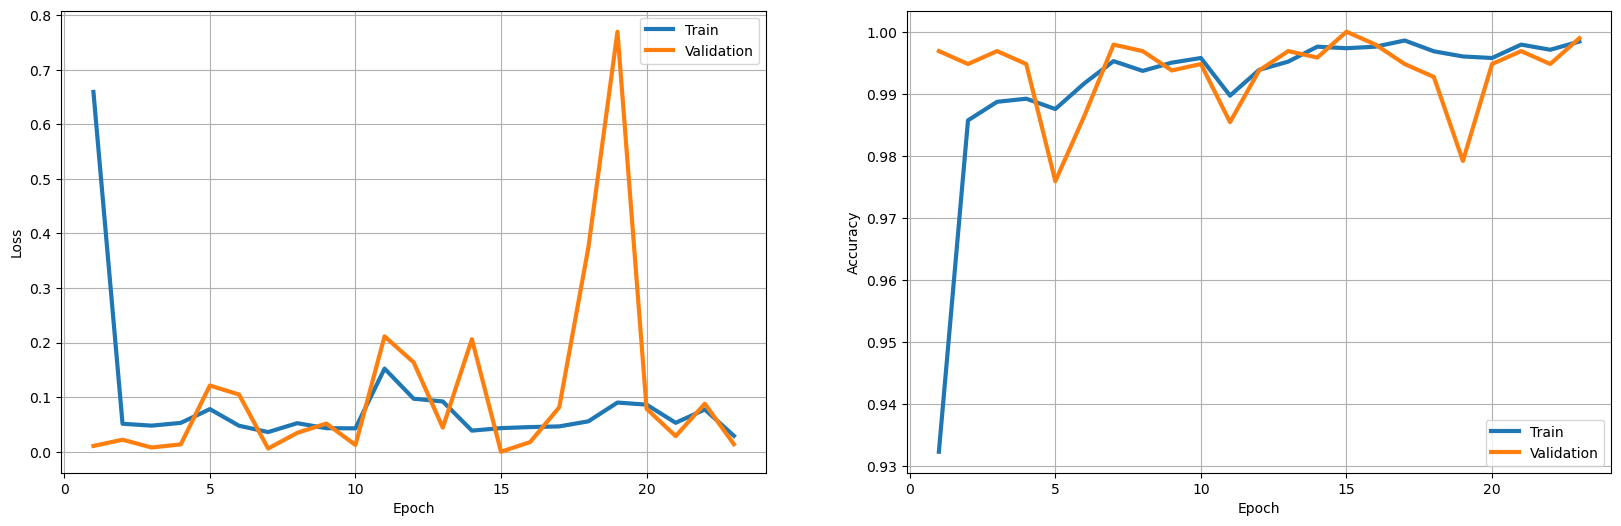

In [141]:
N_EPOCHS = 25
patience = 8
# max_lr = 0.01

optimizer = optim.Adam(our_vgg11_extract.parameters())
# optimizer = optim.AdamW(our_vgg11_extract.parameters())

our_vgg11_extract.apply(weights_init)

# sched = torch.optim.lr_scheduler.OneCycleLR(
#       optimizer,
#       max_lr=max_lr,
#       epochs=N_EPOCHS,
#       steps_per_epoch=len(train_iterator_imagenet)
# )

train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    our_vgg11_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_vgg11_cuda.pt'
                                                                    )

# train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
#                                                                     our_vgg16_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     sched,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_vgg16_cuda.pt'
#                                                                     )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [143]:
model_testing(our_vgg11_extract, valid_iterator_imagenet, criterion, device, model_name='our_vgg11_cuda.pt')

Model name: OurVGG11
Test -- Loss: 0.000, Acc: 100.00 % 



(0.0, 1.0)

### Our VGG16

In [79]:
class OurVGG16(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'OurVGG16'
        
        self.model = model

        # Freeze all "features" layers
        for parameter in self.model.features.parameters():
            parameter.requires_grad = False
        
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.model(x)
        return x

In [80]:
vgg16_bn = models.vgg16_bn(weights="DEFAULT")

our_vgg16_extract = OurVGG16(OUTPUT_DIM, vgg16_bn).to(device)

In [81]:
summary(our_vgg16_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 220.24 s
---------------------------------
Train -- Loss: 0.588, Acc: 92.47%
Val -- Loss: 0.032, Acc: 98.85%

Epoch: 2/25 -- Epoch Time: 222.03 s
---------------------------------
Train -- Loss: 0.081, Acc: 97.82%
Val -- Loss: 0.037, Acc: 98.75%

Epoch: 3/25 -- Epoch Time: 225.43 s
---------------------------------
Train -- Loss: 0.041, Acc: 98.88%
Val -- Loss: 0.037, Acc: 99.17%

Epoch: 4/25 -- Epoch Time: 222.23 s
---------------------------------
Train -- Loss: 0.075, Acc: 98.47%
Val -- Loss: 0.040, Acc: 99.06%

Model checkpoint saved at epoch 4


Epoch: 5/25 -- Epoch Time: 219.82 s
---------------------------------
Train -- Loss: 0.035, Acc: 99.14%
Val -- Loss: 0.026, Acc: 99.38%

Epoch: 6/25 -- Epoch Time: 221.01 s
---------------------------------
Train -- Loss: 0.071, Acc: 98.84%
Val -- Loss: 0.030, Acc: 99.48%

Epoch: 7/25 -- Epoch Time: 223.83 s
---------------------------------
Train -- Loss: 0.037, Acc: 99.22%
V

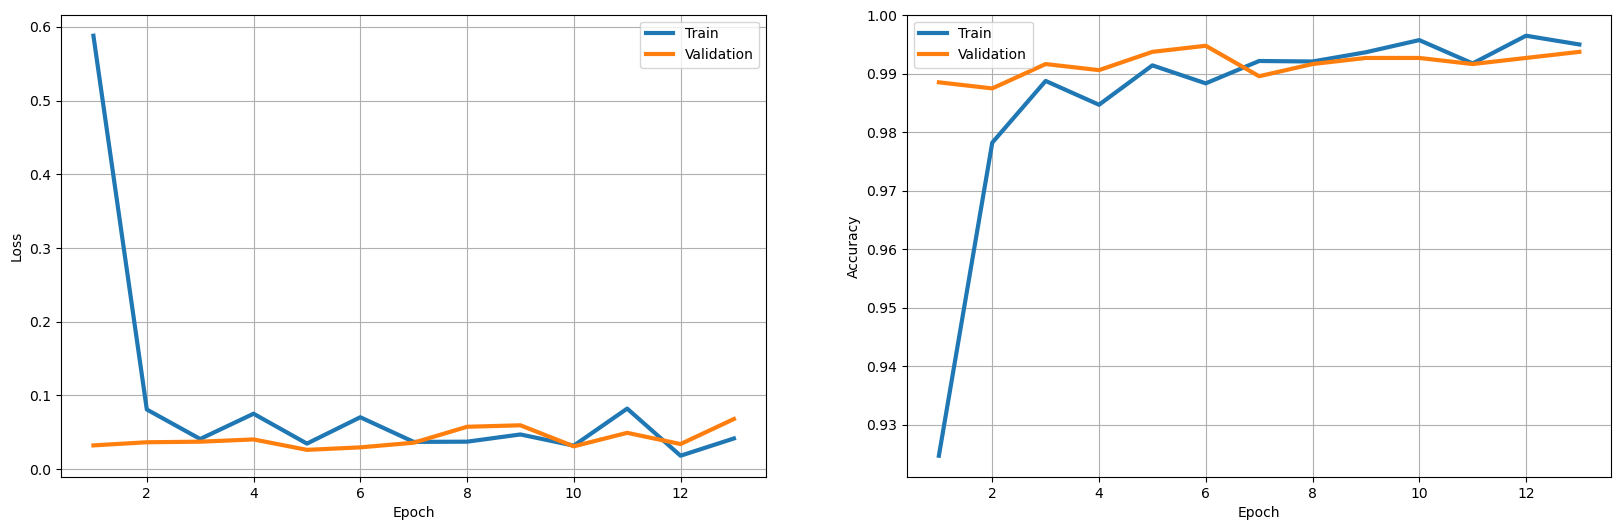

In [147]:
N_EPOCHS = 25
patience = 8
# max_lr = 0.01

optimizer = optim.Adam(our_vgg16_extract.parameters())
# optimizer = optim.AdamW(our_vgg16_extract.parameters())

our_vgg16_extract.apply(weights_init)

# sched = torch.optim.lr_scheduler.OneCycleLR(
#       optimizer,
#       max_lr=max_lr,
#       epochs=N_EPOCHS,
#       steps_per_epoch=len(train_iterator_imagenet)
# )

train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    our_vgg16_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='our_vgg16_cuda.pt'
                                                                    )

# train_losses, train_accs, valid_losses, valid_accs = model_training_sched(N_EPOCHS,
#                                                                     our_vgg16_extract,
#                                                                     train_iterator_imagenet,
#                                                                     valid_iterator_imagenet,
#                                                                     optimizer,
#                                                                     criterion,
#                                                                     sched,
#                                                                     device,
#                                                                     patience=patience,
#                                                                     model_name='our_vgg16_cuda.pt'
#                                                                     )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [148]:
model_testing(our_vgg16_extract, valid_iterator_imagenet, criterion, device, model_name='our_vgg16_cuda.pt')

Model name: OurVGG16
Test -- Loss: 0.026, Acc: 99.38 % 



(0.026, 0.9938)

### VGG16

In [82]:
class VGG16(nn.Module):
    def __init__(self, output_dim, model):
        super().__init__()
        
        self.model_name = 'VGG16'
        
        self.model = model

        # Freeze all "features" layers
        for parameter in self.model.features.parameters():
            parameter.requires_grad = False
        
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.model(x)
        return x

In [83]:
vgg16 = models.vgg16(weights="DEFAULT")

vgg16_extract = VGG16(OUTPUT_DIM, vgg16)

In [84]:
# put this before the summary method if you are on CUDA and after if you are on mps (macos)
vgg16_extract = vgg16_extract.to(device)

In [85]:
summary(vgg16_extract, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [86]:
optimizer = optim.Adam(vgg16_extract.parameters())


Model checkpoint saved at epoch 0


Epoch: 1/25 -- Epoch Time: 240.17 s
---------------------------------
Train -- Loss: 0.310, Acc: 91.61%
Val -- Loss: 0.293, Acc: 95.71%

Model checkpoint saved at epoch 1


Epoch: 2/25 -- Epoch Time: 330.64 s
---------------------------------
Train -- Loss: 0.254, Acc: 97.07%
Val -- Loss: 0.060, Acc: 98.85%

Epoch: 3/25 -- Epoch Time: 341.23 s
---------------------------------
Train -- Loss: 0.187, Acc: 98.07%
Val -- Loss: 0.066, Acc: 98.96%

Epoch: 4/25 -- Epoch Time: 331.01 s
---------------------------------
Train -- Loss: 0.101, Acc: 98.76%
Val -- Loss: 0.068, Acc: 99.17%

Epoch: 5/25 -- Epoch Time: 327.18 s
---------------------------------
Train -- Loss: 0.418, Acc: 97.95%
Val -- Loss: 0.388, Acc: 98.33%

Epoch: 6/25 -- Epoch Time: 327.21 s
---------------------------------
Train -- Loss: 0.187, Acc: 99.09%
Val -- Loss: 0.097, Acc: 98.96%

Epoch: 7/25 -- Epoch Time: 327.06 s
---------------------------------
Train -- Loss: 0.053, Acc: 99.49%
V

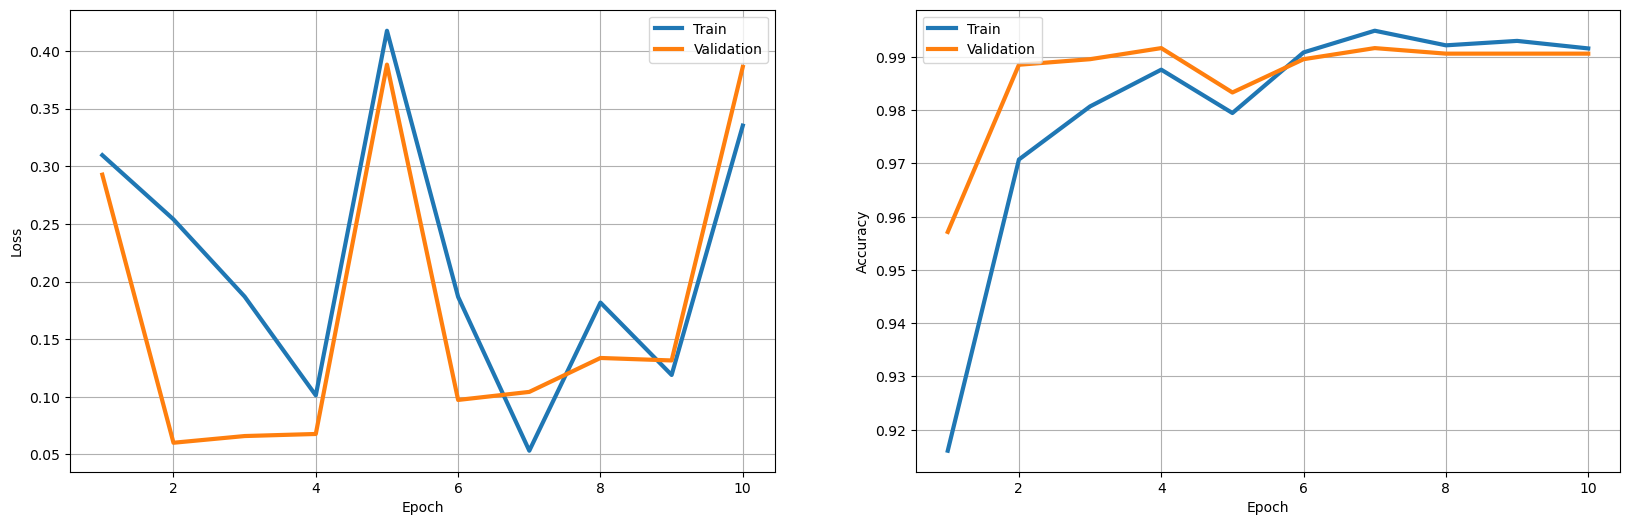

In [154]:
N_EPOCHS = 25
patience = 8
train_losses, train_accs, valid_losses, valid_accs = model_training_patience(N_EPOCHS,
                                                                    vgg16_extract,
                                                                    train_iterator_imagenet,
                                                                    valid_iterator_imagenet,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    patience=patience,
                                                                    model_name='vgg16_cuda.pt'
                                                                    )

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [155]:
model_testing(vgg16_extract, valid_iterator_imagenet, criterion, device, model_name='vgg16_cuda.pt')

Model name: VGG16
Test -- Loss: 0.060, Acc: 98.85 % 



(0.06, 0.9885)

### Testing

In [95]:
test_loss_baseline_cnn, test_accuracy_baseline_cnn = model_testing(baseline_cnn, test_iterator, criterion, device, model_name='baseline_CNN_cuda.pt')
test_loss_densenet121, test_accuracy_densenet121 = model_testing(dense_net121_extract, test_iterator_imagenet, criterion, device, model_name='dense_net121_cuda.pt')
test_loss_efficientnet_b7, test_accuracy_efficientnet_b7 = model_testing(efficientnet_b7_extract, test_iterator_imagenet, criterion, device, model_name='efficientnet_b7_cuda.pt')
test_loss_mobilenetv2, test_accuracy_mobilenetv2 = model_testing(mobilenetv2_extract, test_iterator_imagenet, criterion, device, model_name='mobilenetv2_cuda.pt')
test_loss_resnet50, test_accuracy_resnet50 = model_testing(resnet50_extract, test_iterator_imagenet, criterion, device, model_name='resnet50_cuda.pt')
test_loss_vgg16, test_accuracy_vgg16 = model_testing(vgg16_extract, test_iterator_imagenet, criterion, device, model_name='vgg16_cuda.pt')

Model name: BaselineCNN
Test -- Loss: 0.030, Acc: 99.17 % 

Model name: DenseNet121
Test -- Loss: 0.046, Acc: 98.16 % 

Model name: EfficientNetB7
Test -- Loss: 0.099, Acc: 96.56 % 

Model name: MobileNetV2
Test -- Loss: 0.041, Acc: 98.33 % 

Model name: ResNet50
Test -- Loss: 0.021, Acc: 99.27 % 

Model name: VGG16
Test -- Loss: 0.056, Acc: 99.06 % 



In [96]:
test_loss_our_baseline_cnn, test_accuracy_our_baseline_cnn = model_testing(our_baseline_cnn, test_iterator, criterion, device, model_name='our_baseline_CNN_cuda.pt')
test_loss_our_densenet121, test_accuracy_our_densenet121 = model_testing(our_dense_net121_extract, test_iterator_imagenet, criterion, device, model_name='our_dense_net121_cuda.pt')
test_loss_our_efficientnet_b1, test_accuracy_our_efficientnet_b1 = model_testing(our_efficientnet_b1_extract, test_iterator_imagenet, criterion, device, model_name='our_efficientnet_b1_cuda.pt')
test_loss_our_mobilenetv2, test_accuracy_our_mobilenetv2 = model_testing(our_mobilenetv2_extract, test_iterator_imagenet, criterion, device, model_name='our_mobilenetv2_cuda.pt')
test_loss_our_resnet18, test_accuracy_our_resnet18 = model_testing(our_resnet18_extract, test_iterator_imagenet, criterion, device, model_name='our_resnet18_cuda.pt')
test_loss_our_resnet50, test_accuracy_our_resnet50 = model_testing(our_resnet50_extract, test_iterator_imagenet, criterion, device, model_name='our_resnet50_cuda.pt')
test_loss_our_vgg11, test_accuracy_our_vgg11 = model_testing(our_vgg11_extract, test_iterator_imagenet, criterion, device, model_name='our_vgg11_cuda.pt')
test_loss_our_vgg16, test_accuracy_our_vgg16 = model_testing(our_vgg16_extract, test_iterator_imagenet, criterion, device, model_name='our_vgg16_cuda.pt')

Model name: OurBaselineCNN
Test -- Loss: 0.022, Acc: 99.27 % 

Model name: OurDenseNet121
Test -- Loss: 0.053, Acc: 97.95 % 

Model name: OurEfficientNetB1
Test -- Loss: 0.024, Acc: 99.27 % 

Model name: OurMobileNetV2
Test -- Loss: 0.045, Acc: 98.12 % 

Model name: OurResNet18
Test -- Loss: 0.048, Acc: 98.96 % 

Model name: OurResNet50
Test -- Loss: 0.022, Acc: 99.27 % 

Model name: OurVGG11
Test -- Loss: 0.117, Acc: 99.79 % 

Model name: OurVGG16
Test -- Loss: 0.025, Acc: 99.48 % 



### Report - Our Baseline CNN 

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

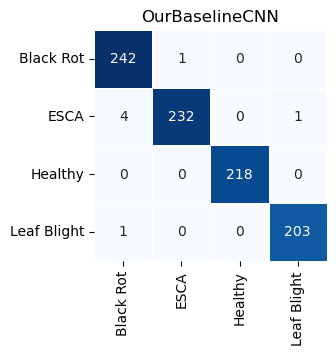


              precision    recall  f1-score   support

   Black Rot       0.98      1.00      0.99       243
        ESCA       1.00      0.98      0.99       237
     Healthy       1.00      1.00      1.00       218
 Leaf Blight       1.00      1.00      1.00       204

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



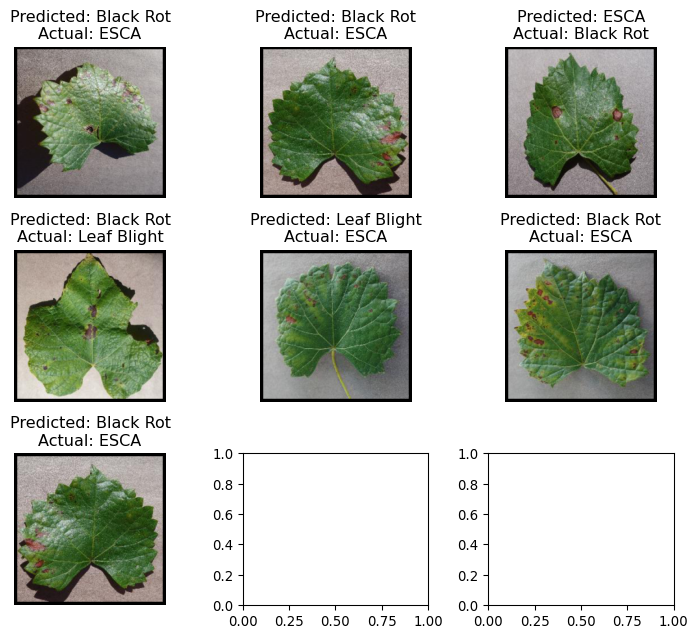

Wrong predictions: 7


In [97]:
# confusion matrix + classification report + error visualization
# use test_iterator and not test_iterator_imagenet (it is not a pretrained model)
nerrors_our_baseline_cnn = print_report(our_baseline_cnn, test_iterator, device, error_rows=3, error_cols=3)

### Report - Baseline CNN 

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

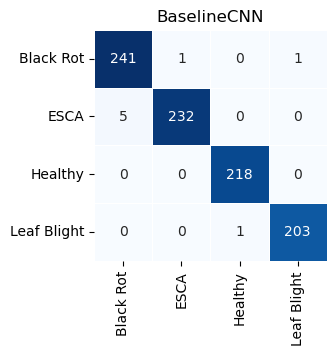


              precision    recall  f1-score   support

   Black Rot       0.98      0.99      0.99       243
        ESCA       1.00      0.98      0.99       237
     Healthy       1.00      1.00      1.00       218
 Leaf Blight       1.00      1.00      1.00       204

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



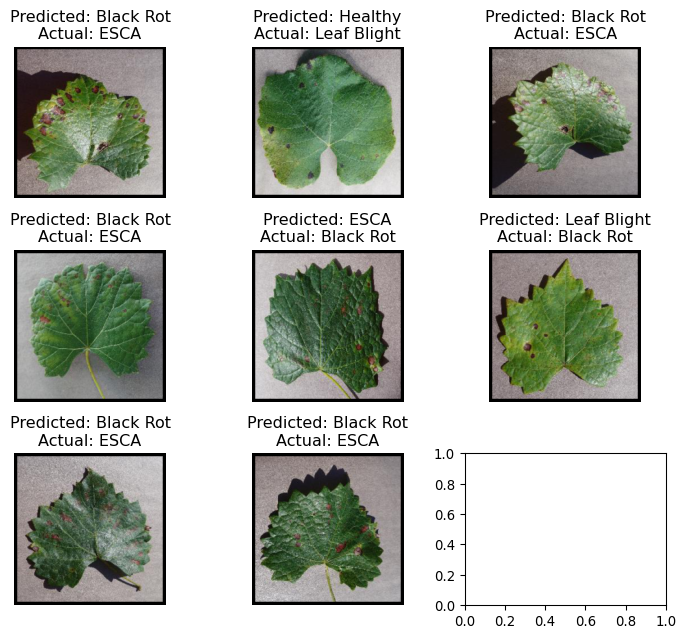

Wrong predictions: 8


In [98]:
# confusion matrix + classification report + error visualization
# use test_iterator and not test_iterator_imagenet (it is not a pretrained model)
nerrors_baseline_cnn = print_report(baseline_cnn, test_iterator, device, error_rows=3, error_cols=3)

### Report - Our DenseNet121

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

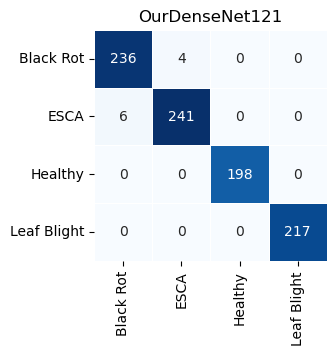


              precision    recall  f1-score   support

   Black Rot       0.98      0.98      0.98       240
        ESCA       0.98      0.98      0.98       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



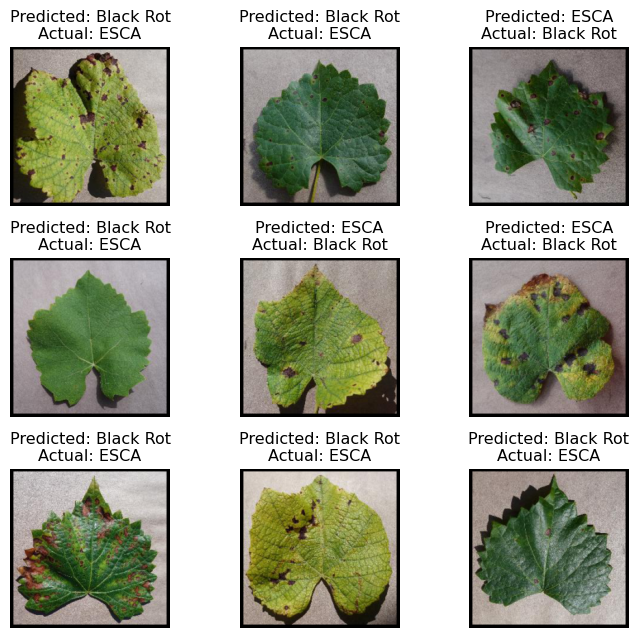

Wrong predictions: 10


In [99]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
nerrors_our_dense_net121 = print_report(our_dense_net121_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - DenseNet121

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

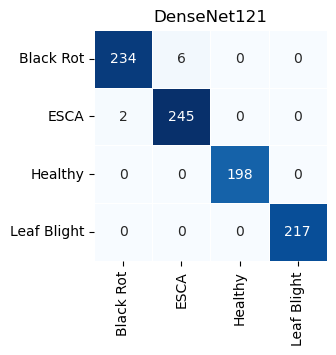


              precision    recall  f1-score   support

   Black Rot       0.99      0.97      0.98       240
        ESCA       0.98      0.99      0.98       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



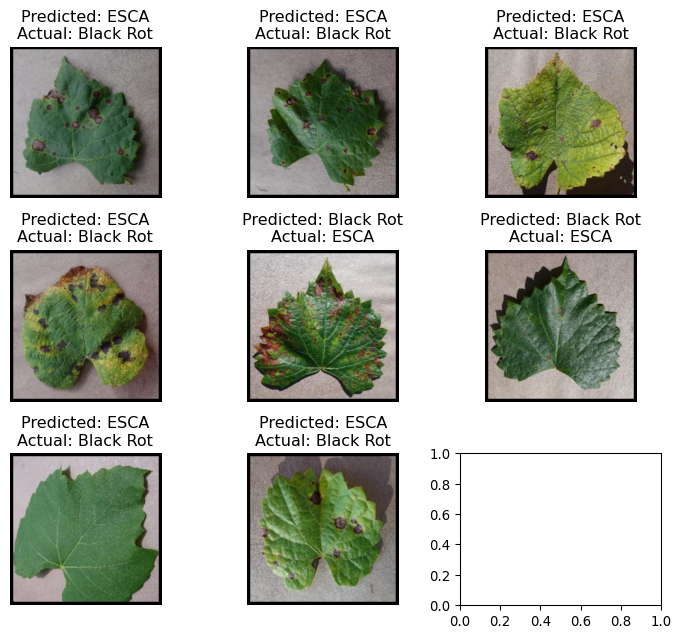

Wrong predictions: 8


In [100]:
nerrors_our_dense_net121 = print_report(dense_net121_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - Our EfficientNetB1

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

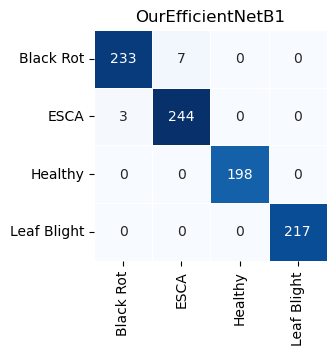


              precision    recall  f1-score   support

   Black Rot       0.99      0.97      0.98       240
        ESCA       0.97      0.99      0.98       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



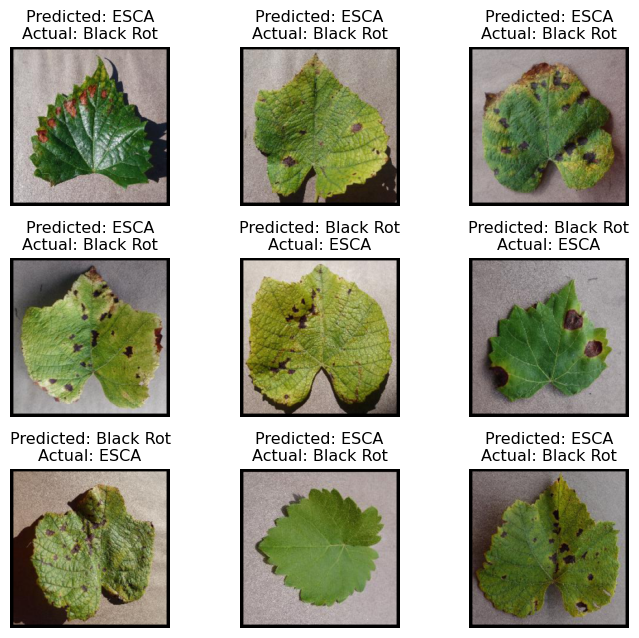

Wrong predictions: 10


In [101]:
nerrors_our_efficientnet_b1 = print_report(our_efficientnet_b1_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - EfficientNetB7

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

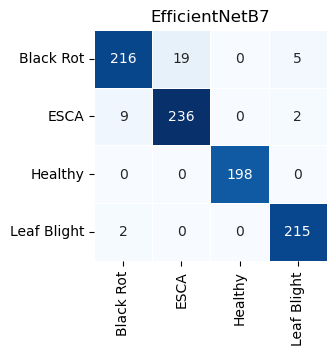


              precision    recall  f1-score   support

   Black Rot       0.95      0.90      0.93       240
        ESCA       0.93      0.96      0.94       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       0.97      0.99      0.98       217

    accuracy                           0.96       902
   macro avg       0.96      0.96      0.96       902
weighted avg       0.96      0.96      0.96       902



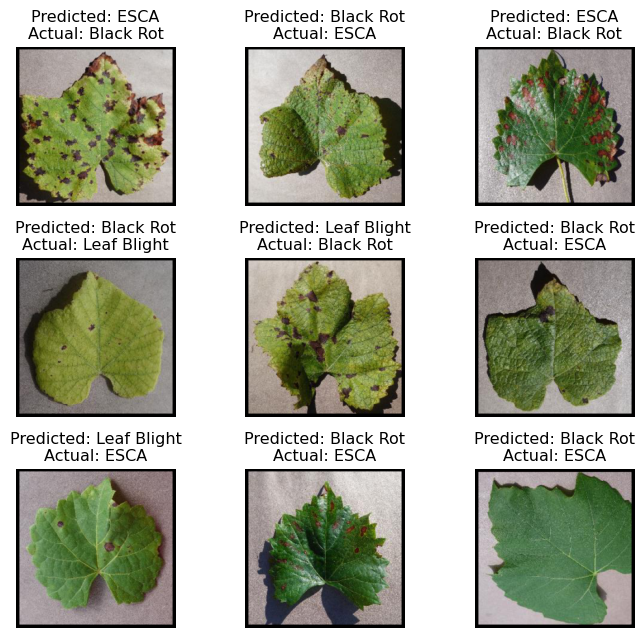

Wrong predictions: 37


In [102]:
nerrors_efficientnet_b7 = print_report(efficientnet_b7_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - Our MobileNetV2

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

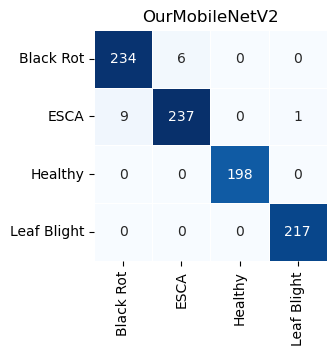


              precision    recall  f1-score   support

   Black Rot       0.96      0.97      0.97       240
        ESCA       0.98      0.96      0.97       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.98       902
   macro avg       0.98      0.98      0.98       902
weighted avg       0.98      0.98      0.98       902



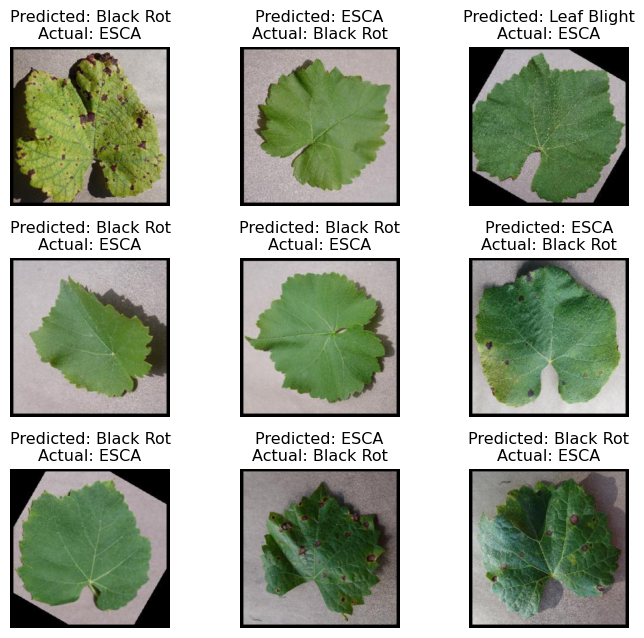

Wrong predictions: 16


In [103]:
nerrors_our_mobilenetv2 = print_report(our_mobilenetv2_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - MobileNetV2

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

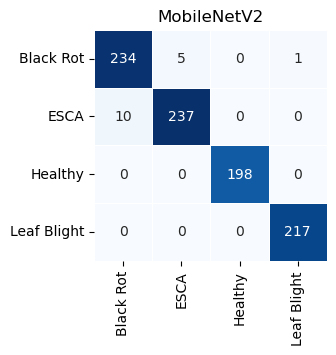


              precision    recall  f1-score   support

   Black Rot       0.96      0.97      0.97       240
        ESCA       0.98      0.96      0.97       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.98       902
   macro avg       0.98      0.98      0.98       902
weighted avg       0.98      0.98      0.98       902



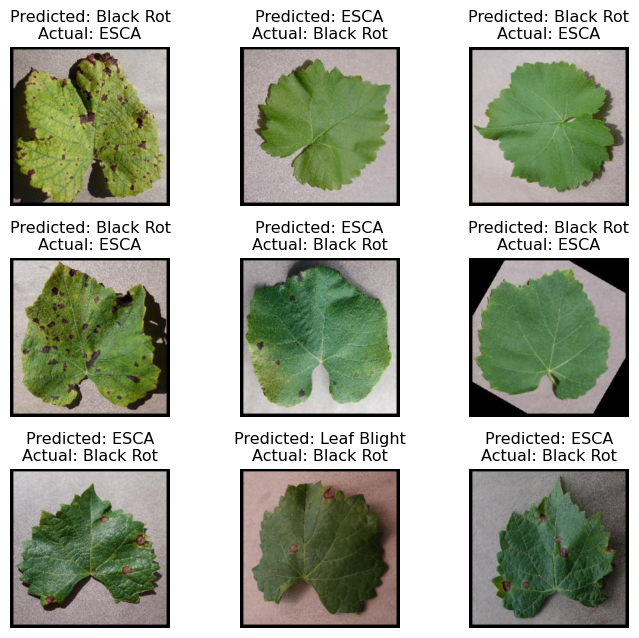

Wrong predictions: 16


In [104]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
nerrors_mobilenetv2 = print_report(mobilenetv2_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - Our ResNet18

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

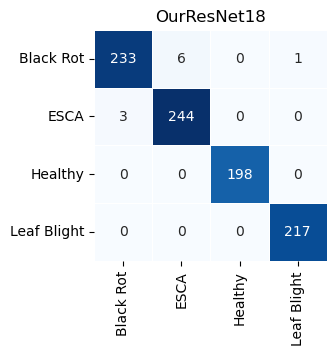


              precision    recall  f1-score   support

   Black Rot       0.99      0.97      0.98       240
        ESCA       0.98      0.99      0.98       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



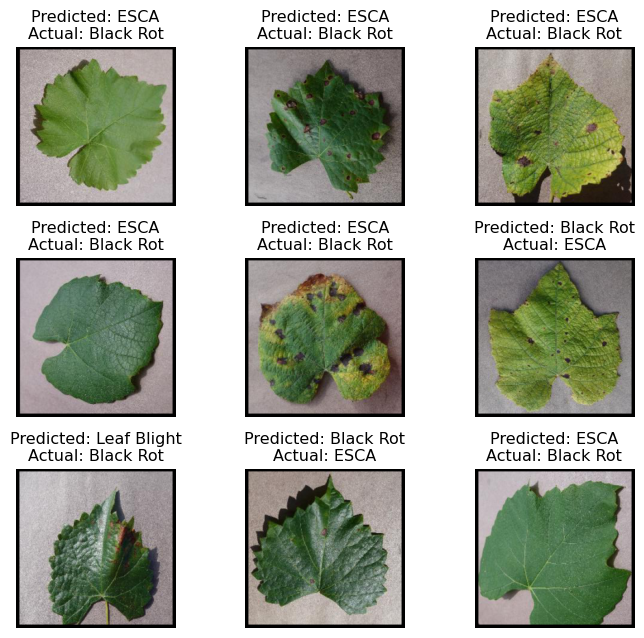

Wrong predictions: 10


In [105]:
nerrors_our_resnet18 = print_report(our_resnet18_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - Our ResNet50

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

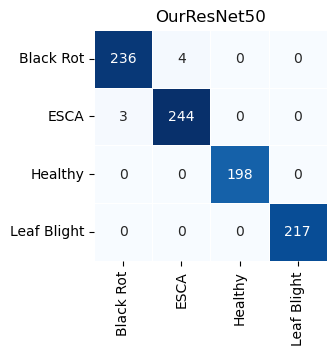


              precision    recall  f1-score   support

   Black Rot       0.99      0.98      0.99       240
        ESCA       0.98      0.99      0.99       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



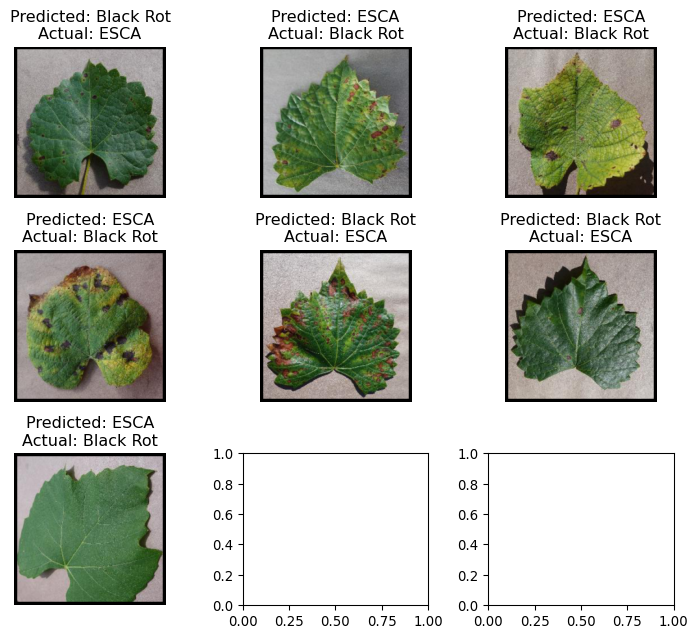

Wrong predictions: 7


In [106]:
nerrors_our_resnet50 = print_report(our_resnet50_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - ResNet50

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

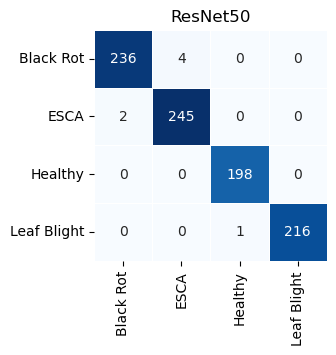


              precision    recall  f1-score   support

   Black Rot       0.99      0.98      0.99       240
        ESCA       0.98      0.99      0.99       247
     Healthy       0.99      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



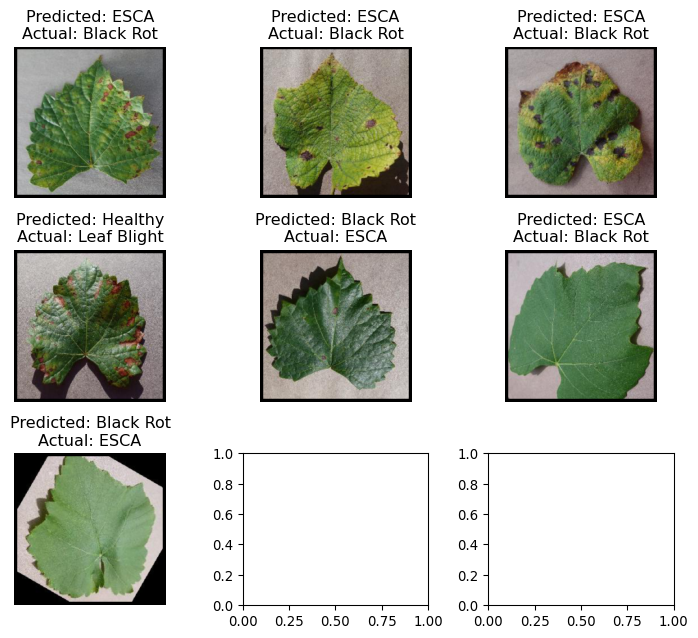

Wrong predictions: 7


In [107]:
# confusion matrix + classification report + error visualization
# use test_iterator_imagenet and not test_iterator
nerrors_resnet50 = print_report(resnet50_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - Our VGG11

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

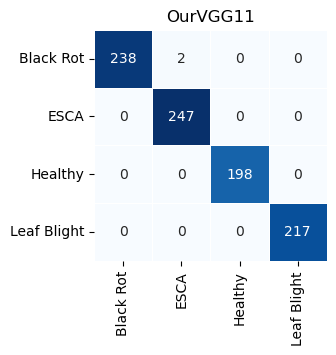


              precision    recall  f1-score   support

   Black Rot       1.00      0.99      1.00       240
        ESCA       0.99      1.00      1.00       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           1.00       902
   macro avg       1.00      1.00      1.00       902
weighted avg       1.00      1.00      1.00       902



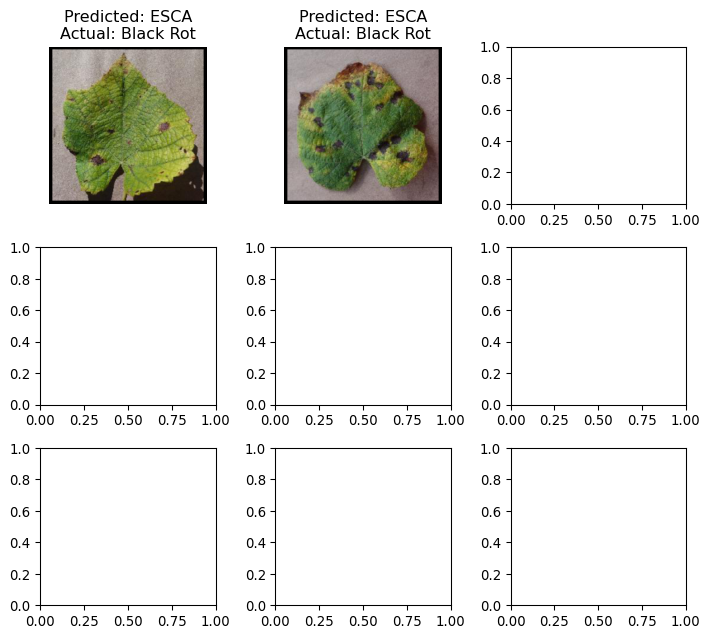

Wrong predictions: 2


In [108]:
nerrors_our_vgg11 = print_report(our_vgg11_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - Our VGG16

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

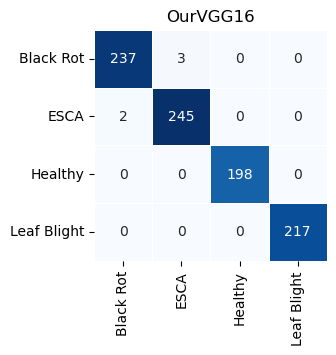


              precision    recall  f1-score   support

   Black Rot       0.99      0.99      0.99       240
        ESCA       0.99      0.99      0.99       247
     Healthy       1.00      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



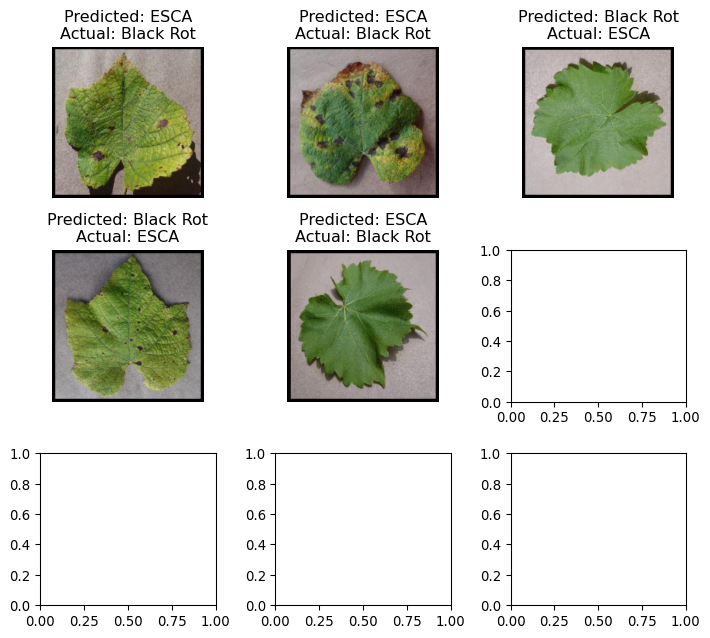

Wrong predictions: 5


In [109]:
nerrors_our_vgg16 = print_report(our_vgg16_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Report - VGG16

> Remember to load the model with the weights using `model.load_state_dict(torch.load("model_name.pt"))` or to execute the previous Testing section 

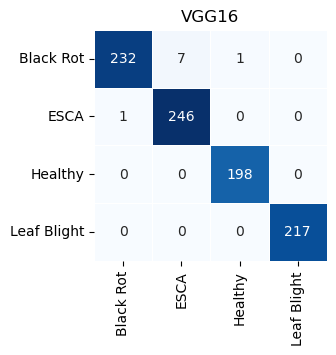


              precision    recall  f1-score   support

   Black Rot       1.00      0.97      0.98       240
        ESCA       0.97      1.00      0.98       247
     Healthy       0.99      1.00      1.00       198
 Leaf Blight       1.00      1.00      1.00       217

    accuracy                           0.99       902
   macro avg       0.99      0.99      0.99       902
weighted avg       0.99      0.99      0.99       902



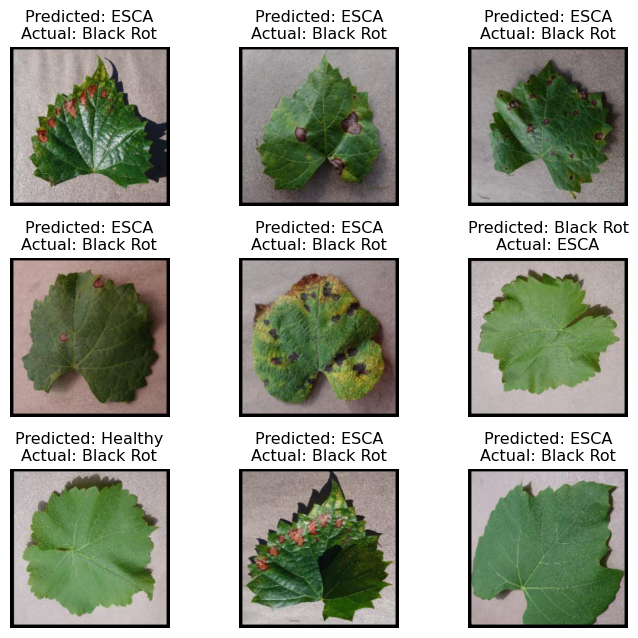

Wrong predictions: 9


In [110]:
nerrors_vgg16 = print_report(vgg16_extract, test_iterator_imagenet, device, error_rows=3, error_cols=3)

### Their models - Results

In [111]:
their_accuracies = {
              'Model':[
                  'Baseline CNN', 
                  'DenseNet121', 
                  'EfficientNetB7', 
                  'MobileNetV2', 
                  'ResNet50', 
                  'VGG16'
                  ],
              'Accuracy':[
                  test_accuracy_baseline_cnn, 
                  test_accuracy_densenet121, 
                  test_accuracy_efficientnet_b7, 
                  test_accuracy_mobilenetv2, 
                  test_accuracy_resnet50, 
                  test_accuracy_vgg16
                  ]
              }

their_accuracies = pd.DataFrame(their_accuracies)
their_accuracies = their_accuracies.sort_values('Accuracy', ascending=False)
their_accuracies

Model  Accuracy
4        ResNet50    0.9927
0    Baseline CNN    0.9917
5           VGG16    0.9906
3     MobileNetV2    0.9833
1     DenseNet121    0.9816
2  EfficientNetB7    0.9656

C:\Users\loren\AppData\Local\Temp\ipykernel_10088\494544765.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=their_accuracies, x='Model', y='Accuracy', palette='inferno')


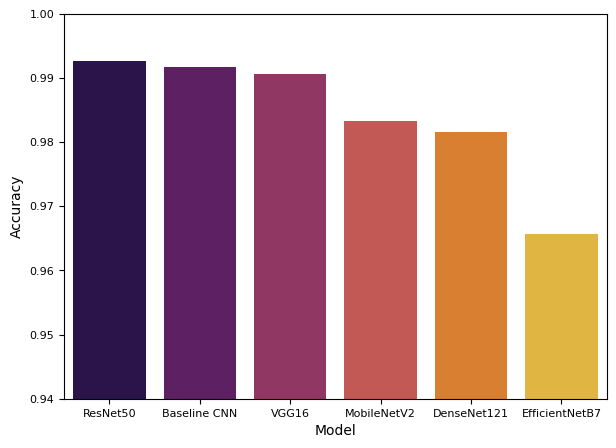

In [112]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.figure(figsize=(7,5), dpi=100)
# plt.title('Accuracies of Different Models')
plt.xticks(rotation=0)
plt.ylim([0.94,1.0])
sns.barplot(data=their_accuracies, x='Model', y='Accuracy', palette='inferno')
plt.show()

In [113]:
# model size = Input size + Forward/backward pass size + Params size
their_model_sizes = {
                'Model':[
                    'Baseline CNN', 
                    'DenseNet121', 
                    'EfficientNetB7', 
                    'MobileNetV2', 
                    'ResNet50', 
                    'VGG16'
                ],
                'Model Size (MB)':[55.06, 5824.16, 1317.47, 161.93, 376.83, 731.57]
               }

their_model_sizes = pd.DataFrame(their_model_sizes)
their_model_sizes = their_model_sizes.sort_values('Model Size (MB)', ascending=False)
their_model_sizes

Model  Model Size (MB)
1     DenseNet121          5824.16
2  EfficientNetB7          1317.47
5           VGG16           731.57
4        ResNet50           376.83
3     MobileNetV2           161.93
0    Baseline CNN            55.06

In [114]:
# model size = Input size + Forward/backward pass size + Params size
their_model_params = {
                    'Model':[
                        'Baseline CNN', 
                        'DenseNet121', 
                        'EfficientNetB7', 
                        'MobileNetV2', 
                        'ResNet50', 
                        'VGG16'
                    ],
                    'Number of parameters':[364580, 6957956, 63797204, 2228996, 23516228, 134276932]
                }

their_model_params = pd.DataFrame(their_model_params)
their_model_params = their_model_params.sort_values('Number of parameters', ascending=False)
their_model_params['Number of parameters'] = their_model_params['Number of parameters'].apply(lambda x: "{:,}".format(x))
their_model_params

Model Number of parameters
5           VGG16          134,276,932
2  EfficientNetB7           63,797,204
4        ResNet50           23,516,228
1     DenseNet121            6,957,956
3     MobileNetV2            2,228,996
0    Baseline CNN              364,580

In [115]:
# model size = Input size + Forward/backward pass size + Params size
their_model_size_accuracy = {
                        'Model Size (MB)':[55.06, 5824.16, 1317.47, 161.93, 376.83, 731.57],
                        'Accuracy':[
                            test_accuracy_baseline_cnn, 
                            test_accuracy_densenet121, 
                            test_accuracy_efficientnet_b7, 
                            test_accuracy_mobilenetv2, 
                            test_accuracy_resnet50, 
                            test_accuracy_vgg16
                            ]
                        }

their_model_size_accuracy = pd.DataFrame(their_model_size_accuracy)
their_model_size_accuracy = their_model_size_accuracy.sort_values('Model Size (MB)', ascending=False)
their_model_size_accuracy

Model Size (MB)  Accuracy
1          5824.16    0.9816
2          1317.47    0.9656
5           731.57    0.9906
4           376.83    0.9927
3           161.93    0.9833
0            55.06    0.9917

### Our models - Results

In [116]:
our_accuracies = {
              'Model':[
                  'Our Baseline CNN', 
                  'Our DenseNet121', 
                  'Our EfficientNetB1', 
                  'Our MobileNetV2', 
                  'Our ResNet18', 
                  'Our ResNet50', 
                  'Our VGG11',
                  'Our VGG16',
                  ],
              'Accuracy':[
                  test_accuracy_our_baseline_cnn, 
                  test_accuracy_our_densenet121, 
                  test_accuracy_our_efficientnet_b1, 
                  test_accuracy_our_mobilenetv2, 
                  test_accuracy_our_resnet18, 
                  test_accuracy_our_resnet50,
                  test_accuracy_our_vgg11,
                  test_accuracy_our_vgg16,
                  ]
              }

our_accuracies = pd.DataFrame(our_accuracies)
our_accuracies = our_accuracies.sort_values('Accuracy', ascending=False)
our_accuracies

Model  Accuracy
6           Our VGG11    0.9979
7           Our VGG16    0.9948
0    Our Baseline CNN    0.9927
2  Our EfficientNetB1    0.9927
5        Our ResNet50    0.9927
4        Our ResNet18    0.9896
3     Our MobileNetV2    0.9812
1     Our DenseNet121    0.9795

C:\Users\loren\AppData\Local\Temp\ipykernel_10088\2859666216.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=our_accuracies, x='Model', y='Accuracy', palette='inferno')


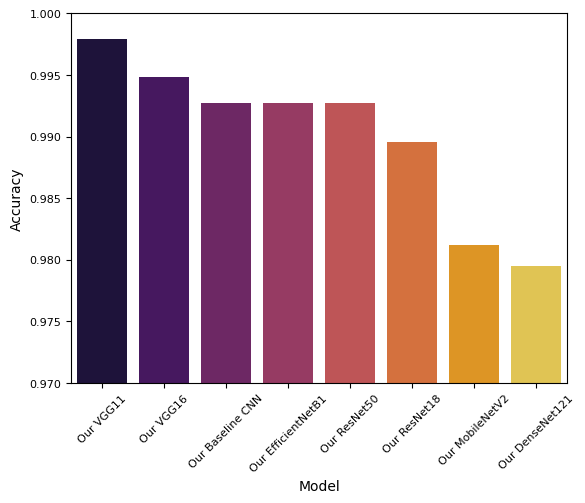

In [117]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.figure()
# plt.title('Accuracies of Different Models')
plt.xticks(rotation=45)
plt.ylim([0.97,1.0])
sns.barplot(data=our_accuracies, x='Model', y='Accuracy', palette='inferno')
plt.show()

In [118]:
# model size = Input size + Forward/backward pass size + Params size
our_model_sizes = {
                'Model':[
                    'Our Baseline CNN', 
                    'Our DenseNet121', 
                    'Our EfficientNetB1', 
                    'Our MobileNetV2', 
                    'Our ResNet18', 
                    'Our ResNet50', 
                    'Our VGG11',
                    'Our VGG16',
                ],
                'Model Size (MB)':[61.41, 5824.16, 270.86, 161.93, 106.00, 376.83, 673.89, 834.97]
               }

our_model_sizes = pd.DataFrame(our_model_sizes)
our_model_sizes = our_model_sizes.sort_values('Model Size (MB)', ascending=False)
our_model_sizes

Model  Model Size (MB)
1     Our DenseNet121          5824.16
7           Our VGG16           834.97
6           Our VGG11           673.89
5        Our ResNet50           376.83
2  Our EfficientNetB1           270.86
3     Our MobileNetV2           161.93
4        Our ResNet18           106.00
0    Our Baseline CNN            61.41

In [119]:
# model size = Input size + Forward/backward pass size + Params size
our_model_params = {
                    'Model':[
                        'Our Baseline CNN', 
                        'Our DenseNet121', 
                        'Our EfficientNetB1', 
                        'Our MobileNetV2', 
                        'Our ResNet18', 
                        'Our ResNet50', 
                        'Our VGG11',
                        'Our VGG16',
                    ],
                    'Number of parameters':[
                        6485956, 
                        6957956, 
                        6518308, 
                        2228996, 
                        11178564, 
                        23516228, 
                        128788228, 
                        134285380,
                    ]
               }

our_model_params = pd.DataFrame(our_model_params)
our_model_params = our_model_params.sort_values('Number of parameters', ascending=False)
our_model_params['Number of parameters'] = our_model_params['Number of parameters'].apply(lambda x: "{:,}".format(x))
our_model_params

Model Number of parameters
7           Our VGG16          134,285,380
6           Our VGG11          128,788,228
5        Our ResNet50           23,516,228
4        Our ResNet18           11,178,564
1     Our DenseNet121            6,957,956
2  Our EfficientNetB1            6,518,308
0    Our Baseline CNN            6,485,956
3     Our MobileNetV2            2,228,996

### Comparing models

In [120]:
accuracies = {
              'Model':[
                  'Baseline CNN',
                  'DenseNet121', 
                  'EfficientNetB7', 
                  'MobileNetV2', 
                  'ResNet50', 
                  'VGG16',
                  'Our Baseline CNN', 
                  'Our DenseNet121', 
                  'Our EfficientNetB1', 
                  'Our MobileNetV2', 
                  'Our ResNet18', 
                  'Our ResNet50', 
                  'Our VGG11',
                  'Our VGG16',
                  ],
              'Accuracy':[
                  test_accuracy_baseline_cnn, 
                  test_accuracy_densenet121, 
                  test_accuracy_efficientnet_b7, 
                  test_accuracy_mobilenetv2, 
                  test_accuracy_resnet50, 
                  test_accuracy_vgg16,
                  test_accuracy_our_baseline_cnn, 
                  test_accuracy_our_densenet121, 
                  test_accuracy_our_efficientnet_b1, 
                  test_accuracy_our_mobilenetv2, 
                  test_accuracy_our_resnet18, 
                  test_accuracy_our_resnet50,
                  test_accuracy_our_vgg11,
                  test_accuracy_our_vgg16,
                  ]
              }

accuracies = pd.DataFrame(accuracies)
accuracies = accuracies.sort_values('Accuracy', ascending=False)
accuracies

Model  Accuracy
12           Our VGG11    0.9979
13           Our VGG16    0.9948
4             ResNet50    0.9927
6     Our Baseline CNN    0.9927
8   Our EfficientNetB1    0.9927
11        Our ResNet50    0.9927
0         Baseline CNN    0.9917
5                VGG16    0.9906
10        Our ResNet18    0.9896
3          MobileNetV2    0.9833
1          DenseNet121    0.9816
9      Our MobileNetV2    0.9812
7      Our DenseNet121    0.9795
2       EfficientNetB7    0.9656

C:\Users\loren\AppData\Local\Temp\ipykernel_10088\745827724.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracies, x='Model', y='Accuracy', palette='inferno')


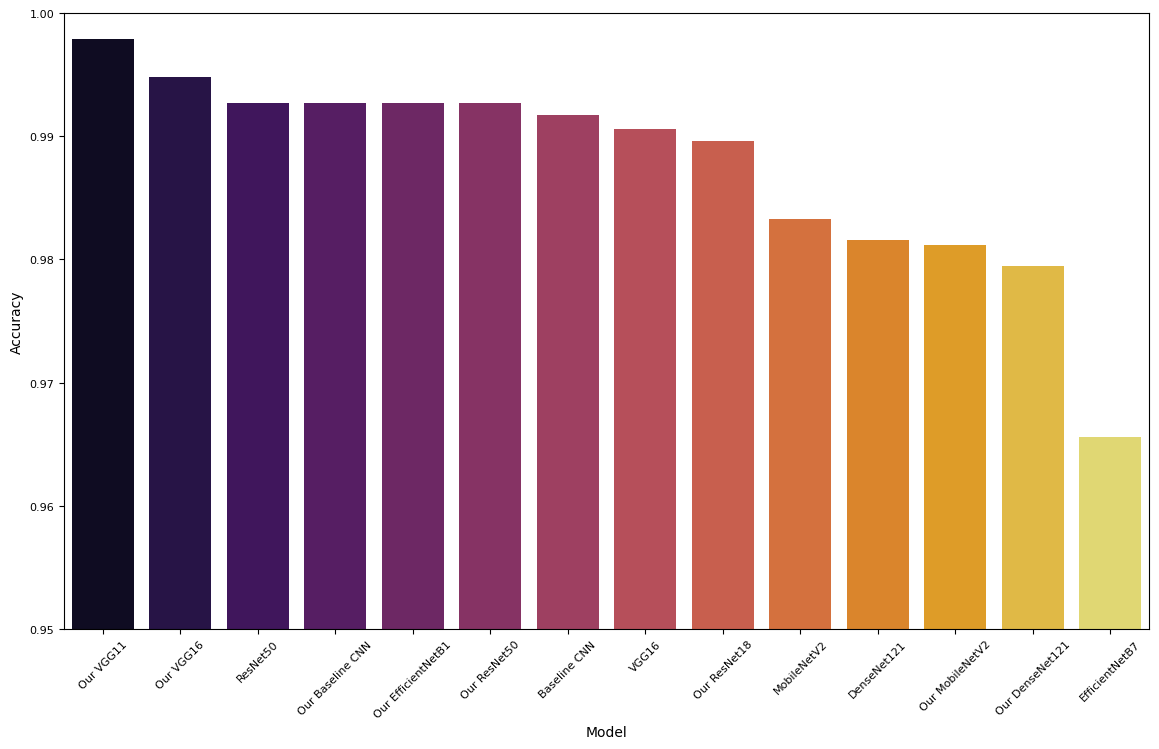

In [121]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.figure(figsize=(14, 8))
# plt.title('Accuracies of Different Models')
plt.xticks(rotation=45)
plt.ylim([0.95,1.0])
sns.barplot(data=accuracies, x='Model', y='Accuracy', palette='inferno')
plt.show()

In [122]:
nerrors = {
        'Model':[
            'Baseline CNN',
            'DenseNet121', 
            'EfficientNetB7', 
            'MobileNetV2', 
            'ResNet50', 
            'VGG16',
            'Our Baseline CNN', 
            'Our DenseNet121', 
            'Our EfficientNetB1', 
            'Our MobileNetV2', 
            'Our ResNet18', 
            'Our ResNet50', 
            'Our VGG11',
            'Our VGG16',
            ],
        'Wrong predictions':[
            nerrors_baseline_cnn, 
            nerrors_our_dense_net121, 
            nerrors_efficientnet_b7, 
            nerrors_mobilenetv2, 
            nerrors_resnet50, 
            nerrors_vgg16,
            nerrors_our_baseline_cnn, 
            nerrors_our_dense_net121, 
            nerrors_our_efficientnet_b1, 
            nerrors_our_mobilenetv2, 
            nerrors_our_resnet18, 
            nerrors_our_resnet50,
            nerrors_our_vgg11,
            nerrors_our_vgg16,
            ]
        }

nerrors = pd.DataFrame(nerrors)
nerrors = nerrors.sort_values('Wrong predictions', ascending=True)
nerrors

Model  Wrong predictions
12           Our VGG11                  2
13           Our VGG16                  5
4             ResNet50                  7
6     Our Baseline CNN                  7
11        Our ResNet50                  7
0         Baseline CNN                  8
1          DenseNet121                  8
7      Our DenseNet121                  8
5                VGG16                  9
8   Our EfficientNetB1                 10
10        Our ResNet18                 10
3          MobileNetV2                 16
9      Our MobileNetV2                 16
2       EfficientNetB7                 37

### Their Max-Voting Ensemble


> Remember to execute the Testing section first

In [123]:
true_labels, vgg16_preds= predict(vgg16_extract, test_iterator_imagenet, device)
_, baseline_cnn_preds= predict(baseline_cnn, test_iterator, device)
_, resnet50_extract_preds= predict(resnet50_extract, test_iterator_imagenet, device)

In [124]:
ensemble_preds = max_voting_ensemble(vgg16_preds, baseline_cnn_preds, resnet50_extract_preds)
calculate_accuracy_ensemble(ensemble_preds, true_labels)

0.9889

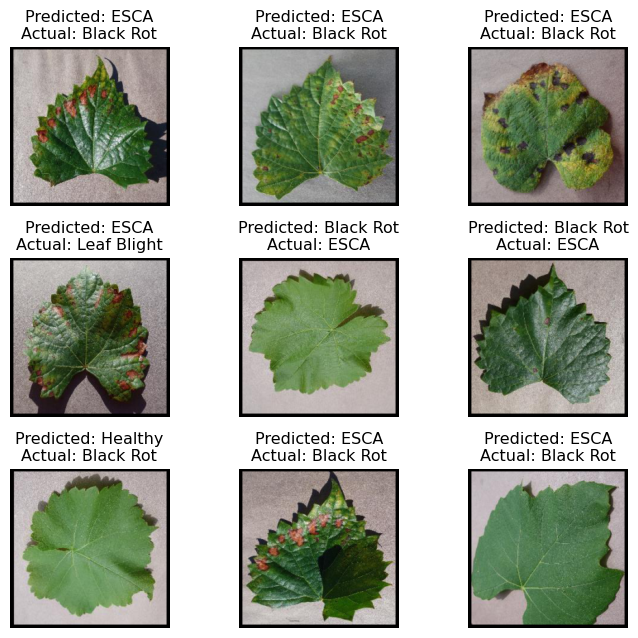

Wrong predictions: 10


In [125]:
nerrors_their_ensemble = visualize_errors(true_labels, ensemble_preds, 3, 3)

### Our Max-Voting Ensemble

> Remember to execute the Testing section first

In [126]:
true_labels, our_vgg11_preds= predict(our_vgg11_extract, test_iterator_imagenet, device)
_, our_baseline_cnn_preds= predict(our_baseline_cnn, test_iterator, device)
_, our_efficientnet_b1_preds= predict(our_efficientnet_b1_extract, test_iterator_imagenet, device)

In [127]:
our_ensemble_preds = max_voting_ensemble(our_vgg11_preds, our_baseline_cnn_preds, our_efficientnet_b1_preds)
calculate_accuracy_ensemble(our_ensemble_preds, true_labels)

0.9956

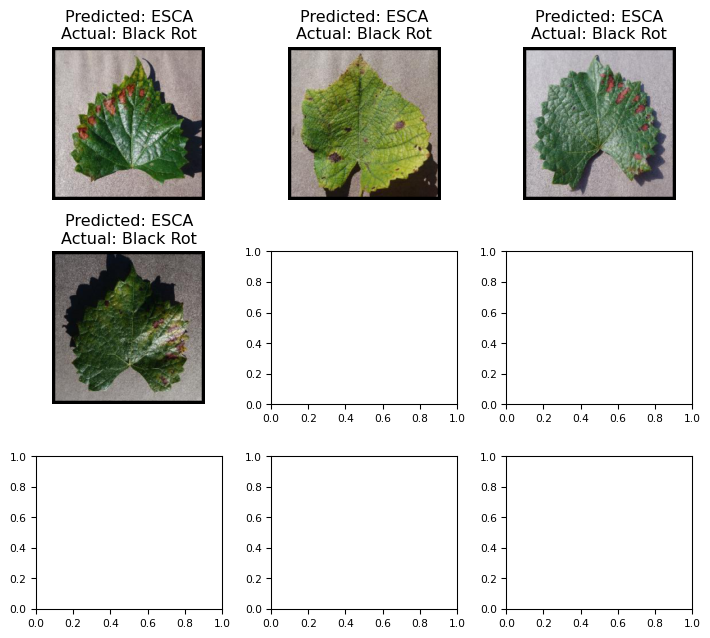

Wrong predictions: 4


In [128]:
nerrors_our_ensemble = visualize_errors(true_labels, our_ensemble_preds, 3, 3)

### Efficiency Test

> Remember to execute the Testing section first

In [129]:
start = time.time()

_, vgg16_preds= predict(vgg16_extract, test_iterator_imagenet, device)
_, baseline_cnn_preds= predict(baseline_cnn, test_iterator, device)
_, resnet50_extract_preds= predict(resnet50_extract, test_iterator_imagenet, device)
ensemble_preds = max_voting_ensemble(vgg16_preds, baseline_cnn_preds, resnet50_extract_preds)

end = time.time()

print(f'It takes the max-voting ensemble {round((end-start)/1.805,2)} milliseconds to predict a single image.')

It takes the max-voting ensemble 18.82 milliseconds to predict a single image.


In [130]:
start = time.time()

_, our_vgg11_preds= predict(our_vgg11_extract, test_iterator_imagenet, device)
_, our_baseline_cnn_preds= predict(our_baseline_cnn, test_iterator, device)
_, our_efficientnet_b1_preds= predict(our_efficientnet_b1_extract, test_iterator_imagenet, device)
our_ensemble_preds = max_voting_ensemble(our_vgg11_preds, our_baseline_cnn_preds, our_efficientnet_b1_preds)

end = time.time()

print(f'It takes the max-voting ensemble {round((end-start)/1.805,2)} milliseconds to predict a single image.')

It takes the max-voting ensemble 16.94 milliseconds to predict a single image.
